# InfoGAN 

- Discrete category + continuous category

<img src="./infogan.png" width="400">

## 1. Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

## 2. Hyperparameter & Data setting

In [2]:
# Set Hyperparameters

epoch = 50
batch_size = 128
learning_rate = 0.0002
num_gpus = 1
z_size= 62
discrete_latent_size = 10
contin_latent_size = 2
ratio = 1

# Download Data & Set Data Loader(input pipeline)

mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]),
                        target_transform=None,
                        download=True)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

## 3. Label into one-hot vector

In [3]:
def int_to_onehot(z_label):
    one_hot_array = np.zeros(shape=[len(z_label), discrete_latent_size])
    one_hot_array[np.arange(len(z_label)), z_label] = 1
    return one_hot_array

## 4. Generator

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
                    nn.Linear(z_size+discrete_latent_size+contin_latent_size,1024),
                    nn.BatchNorm1d(1024),
                    nn.ReLU(),               
                    nn.Linear(1024,7*7*256),               
                    nn.BatchNorm1d(7*7*256),
                    nn.ReLU(), 
            )              
        self.layer2 = nn.Sequential(OrderedDict([
                ('conv1', nn.ConvTranspose2d(256,128,3,2,1,1)), # [batch,256,7,7] -> [batch,128,14,14]
                ('bn1', nn.BatchNorm2d(128)),    
                ('relu1', nn.ReLU()),
                ('conv2', nn.ConvTranspose2d(128,64,3,1,1)),    # [batch,128,14,14] -> [batch,64,14,14]
                ('bn2', nn.BatchNorm2d(64)),    
                ('relu2', nn.ReLU()),
                
            ]))
        self.layer3 = nn.Sequential(OrderedDict([
                ('conv3',nn.ConvTranspose2d(64,32,3,1,1)),      # [batch,64,14,14] -> [batch,16,14,14]
                ('bn3',nn.BatchNorm2d(32)),    
                ('relu3',nn.ReLU()),
                ('conv4',nn.ConvTranspose2d(32,1,3,2,1,1)),     # [batch,16,14,14] -> [batch,1,28,28]
                ('tanh',nn.Tanh())
            ]))

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(batch_size//num_gpus,256,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out


## 5. Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                ('conv1',nn.Conv2d(1,32,3,stride=2,padding=1)),        # [batch,1,28,28] -> [batch,32,14,14]
                ('relu1',nn.LeakyReLU(0.1)),
                ('conv2',nn.Conv2d(32,64,3,stride=2,padding=1)),      # [batch,32,14,14] -> [batch,64,7,7]
                ('bn2',nn.BatchNorm2d(64)),    
                ('relu2',nn.LeakyReLU(0.1)),
            ]))
        
        self.layer2 = nn.Sequential(
                nn.Linear(64*7*7,256),
                nn.BatchNorm1d(256),
                nn.LeakyReLU(0.1),
                nn.Linear(256,1+discrete_latent_size+contin_latent_size) # GAN + Category + Continuous
            )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        out = self.layer1(x)
        out = out.view(batch_size//num_gpus, -1)
        
        out = self.layer2(out)  
                
        output = self.sigmoid(out[:,0:1])
        onehot = self.sigmoid(out[:,1:11])
        contin = out[:,11:]
        
        return output,onehot,contin

## 6. Instance & Label on GPU

In [6]:
# put class instance on multi gpu

generator = nn.DataParallel(Generator(),device_ids=[0])
discriminator = nn.DataParallel(Discriminator(),device_ids=[0])

# put labels on multi gpu

ones_label = Variable(torch.ones(batch_size,1)).cuda()
zeros_label = Variable(torch.zeros(batch_size,1)).cuda()

## 7. Loss function & Optimizer

In [7]:
gan_loss_func = nn.BCELoss()
cat_loss_func = nn.CrossEntropyLoss()
contin_loss_func = nn.MSELoss()

gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

## 8. Model restore

In [8]:
try:
    generator, discriminator = torch.load('./model/infogan_catcon.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



In [9]:
def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(10):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

def contin_check(i):
    for j in range(10):
        z_random = np.random.rand(batch_size,z_size)
        z_onehot = np.random.randint(0, 10, size=batch_size)
        z_contin = np.random.uniform(-1,1,size=[batch_size,2])

        # change first 10 labels from random to 0~9          
        for l in range(40):
            z_onehot[l]=j

            if l <= 20: 
                z_contin[l,0]= (l-10)/5
                z_contin[l,1]= 0 
                
            else:      
                z_contin[l,0]= 0
                z_contin[l,1]= (l-30)/5

        #print(z_contin)

        # preprocess z
        z_label_onehot = int_to_onehot(z_onehot)
        z_concat = np.concatenate([z_random, z_label_onehot,z_contin], axis=1)
        z = Variable(torch.from_numpy(z_concat).type_as(torch.FloatTensor())).cuda()

        gen_fake = generator.forward(z)

        v_utils.save_image(gen_fake.data[0:40],"./result_contin/gen_{}_{}.png".format(i,j),nrow=10)

## 9. Train Model

/home/gunho/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/gunho/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0th iteration gen_loss: 
 3.2939
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 4.1303
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0th iteration gen_loss: 
 2.6272
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 3.3648
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0th iteration gen_loss: 
 2.5978
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 3.3421
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0th iteration gen_loss: 
 2.5879
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 3.3431
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0th iteration gen_loss: 
 2.5790
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 3.2888
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0th iteration gen_loss: 
 2.5559
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 3.2839
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0th iteration gen_loss: 
 2.5461
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 3.2394
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0th iteration gen_lo

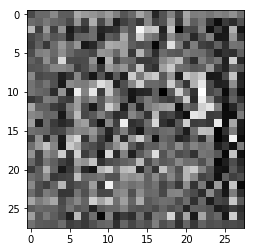

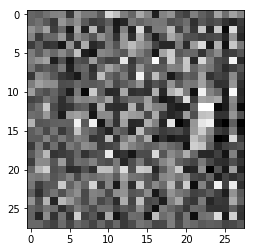

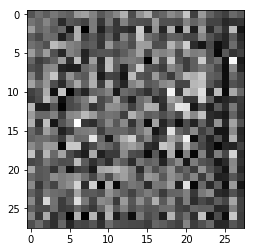

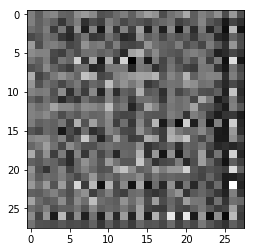

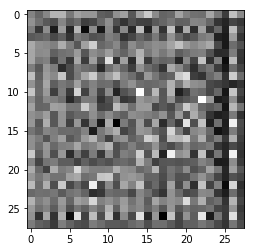

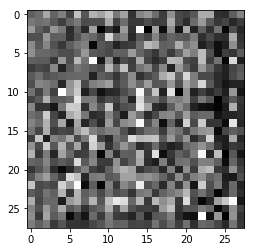

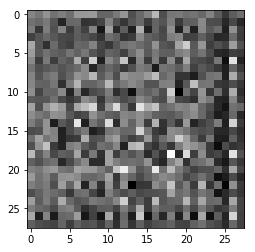

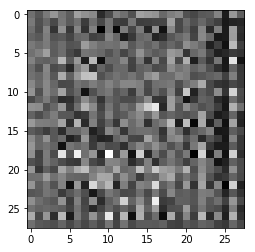

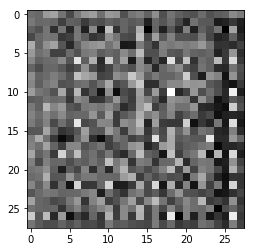

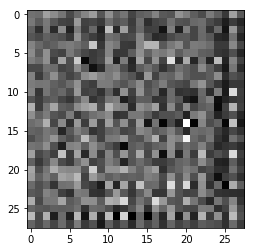

1th iteration gen_loss: 
 2.6830
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4789
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1th iteration gen_loss: 
 2.7395
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4984
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1th iteration gen_loss: 
 2.8359
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5834
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1th iteration gen_loss: 
 2.6457
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7398
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1th iteration gen_loss: 
 2.6801
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6832
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1th iteration gen_loss: 
 2.6710
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7309
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1th iteration gen_loss: 
 2.7429
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7046
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1th iteration gen_lo

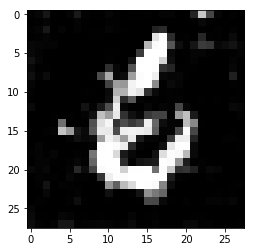

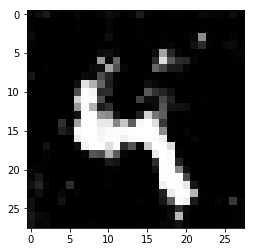

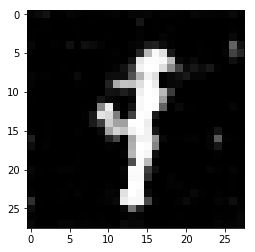

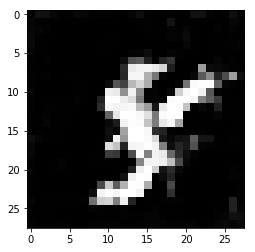

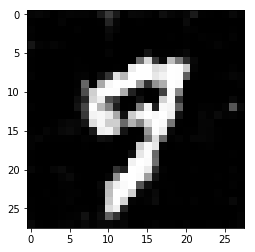

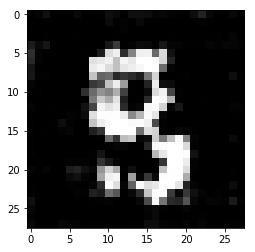

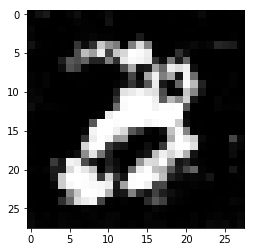

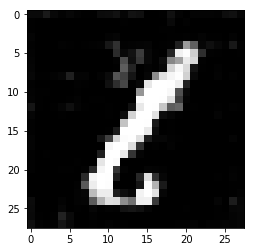

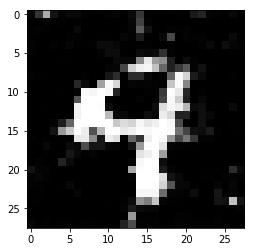

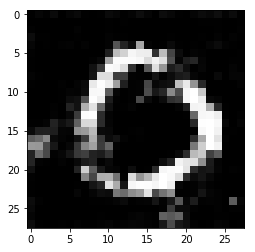

2th iteration gen_loss: 
 2.3572
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8135
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2th iteration gen_loss: 
 2.3758
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8569
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2th iteration gen_loss: 
 2.3546
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8185
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2th iteration gen_loss: 
 2.3439
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8306
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2th iteration gen_loss: 
 2.3785
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7867
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2th iteration gen_loss: 
 2.3539
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8363
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2th iteration gen_loss: 
 2.3609
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8626
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2th iteration gen_lo

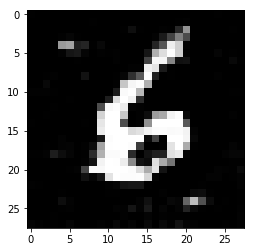

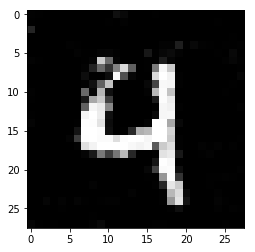

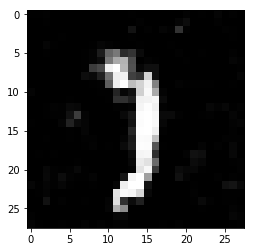

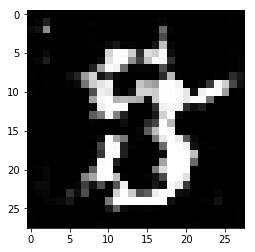

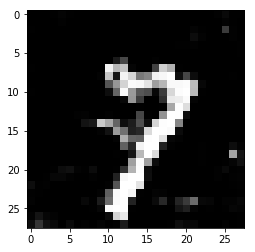

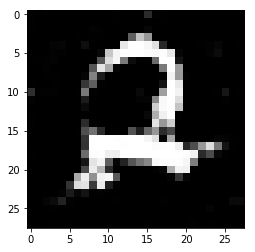

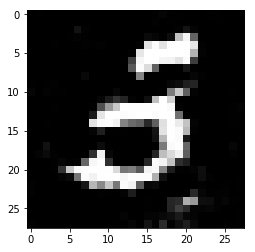

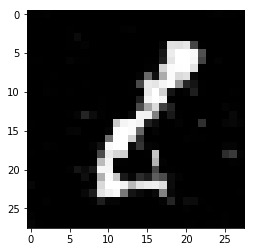

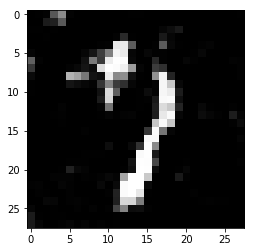

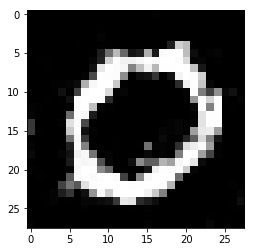

3th iteration gen_loss: 
 2.3291
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8194
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3th iteration gen_loss: 
 2.3541
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8167
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3th iteration gen_loss: 
 2.3109
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8134
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3th iteration gen_loss: 
 2.3365
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7547
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3th iteration gen_loss: 
 2.3291
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8299
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3th iteration gen_loss: 
 2.3512
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8312
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3th iteration gen_loss: 
 2.3319
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7942
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3th iteration gen_lo

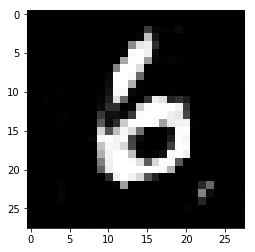

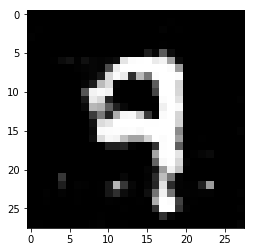

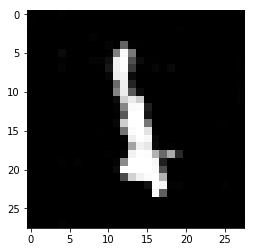

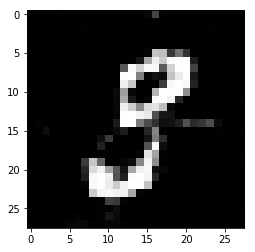

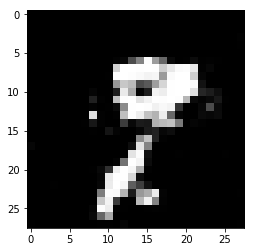

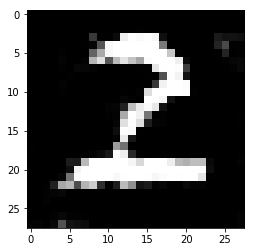

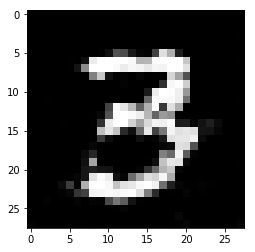

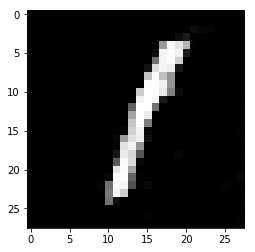

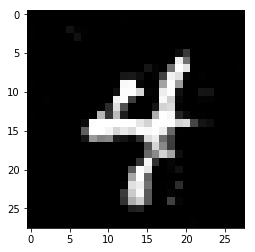

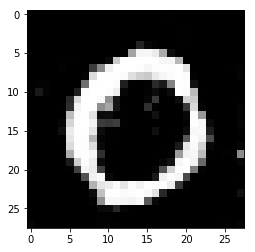

4th iteration gen_loss: 
 2.2928
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8404
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4th iteration gen_loss: 
 2.2968
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8493
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4th iteration gen_loss: 
 2.3476
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7912
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4th iteration gen_loss: 
 2.3225
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7660
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4th iteration gen_loss: 
 2.2878
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8219
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4th iteration gen_loss: 
 2.3137
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8037
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4th iteration gen_loss: 
 2.2932
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8400
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4th iteration gen_lo

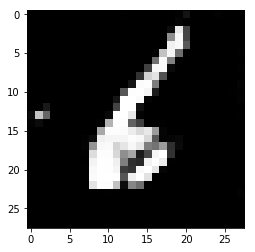

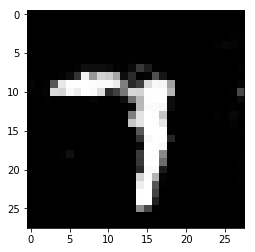

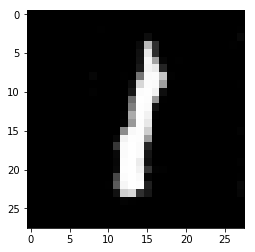

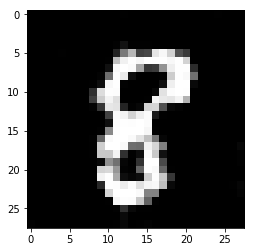

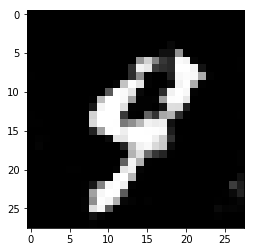

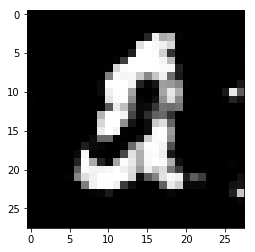

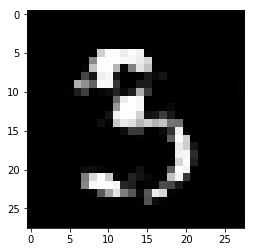

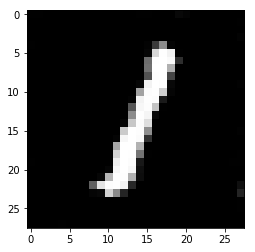

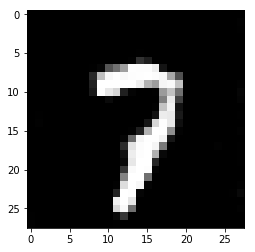

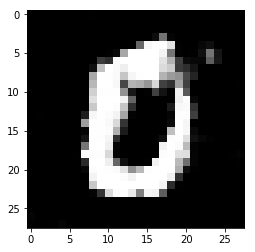

5th iteration gen_loss: 
 2.3213
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8363
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5th iteration gen_loss: 
 2.3173
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8200
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5th iteration gen_loss: 
 2.2831
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8449
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5th iteration gen_loss: 
 2.3385
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8610
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5th iteration gen_loss: 
 2.3260
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8459
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5th iteration gen_loss: 
 2.3148
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7797
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5th iteration gen_loss: 
 2.3135
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8141
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5th iteration gen_lo

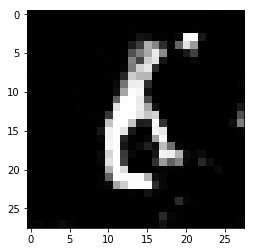

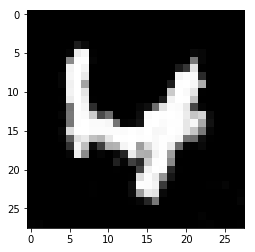

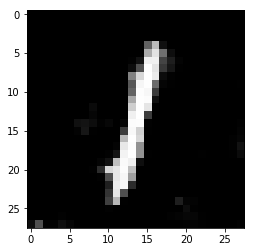

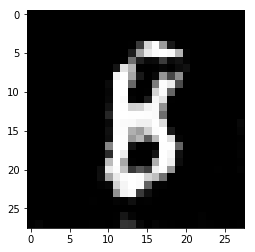

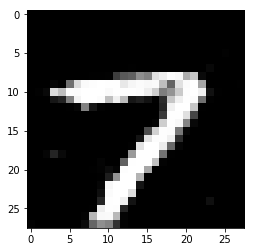

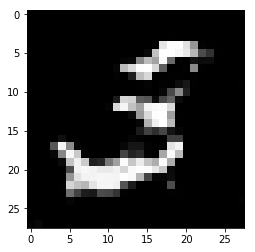

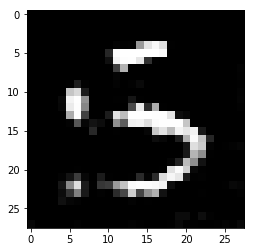

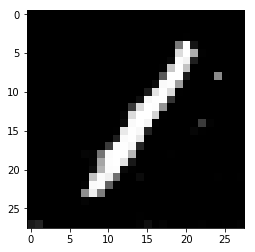

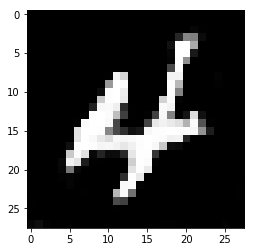

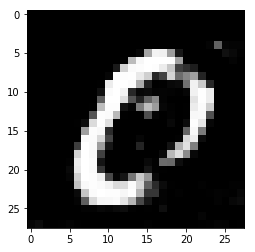

6th iteration gen_loss: 
 2.3265
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7696
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6th iteration gen_loss: 
 2.3026
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8338
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6th iteration gen_loss: 
 2.2918
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8053
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6th iteration gen_loss: 
 2.3250
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8314
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6th iteration gen_loss: 
 2.2934
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8040
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6th iteration gen_loss: 
 2.2952
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7909
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6th iteration gen_loss: 
 2.3442
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7814
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6th iteration gen_lo

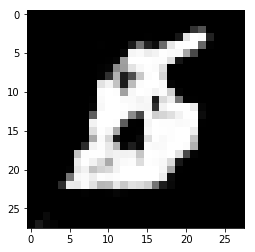

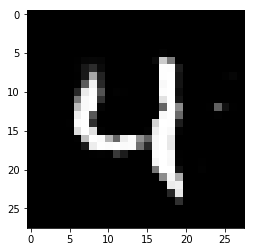

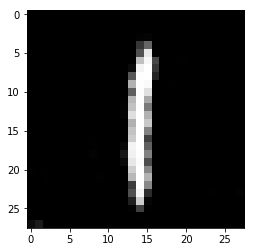

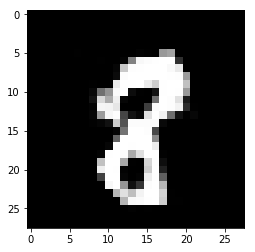

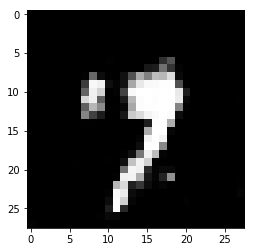

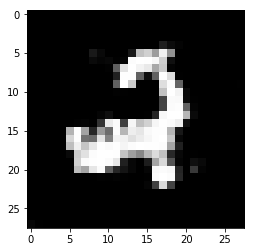

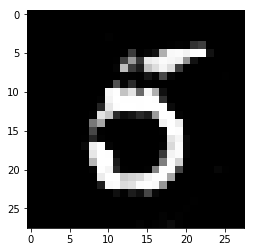

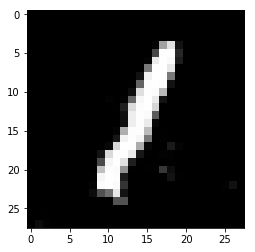

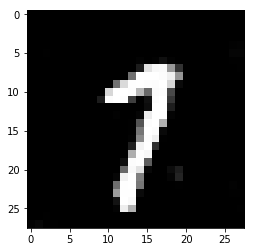

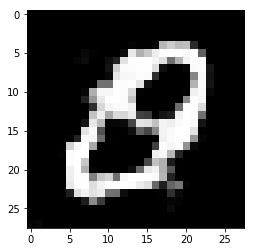

7th iteration gen_loss: 
 2.3045
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7963
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7th iteration gen_loss: 
 2.2908
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7555
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7th iteration gen_loss: 
 2.3221
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7957
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7th iteration gen_loss: 
 2.3454
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7797
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7th iteration gen_loss: 
 2.2897
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7935
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7th iteration gen_loss: 
 2.3423
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7684
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7th iteration gen_loss: 
 2.2865
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8380
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7th iteration gen_lo

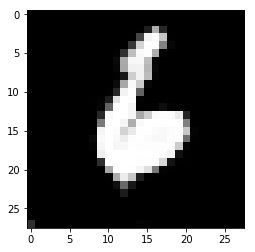

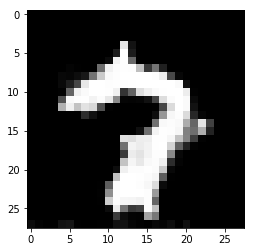

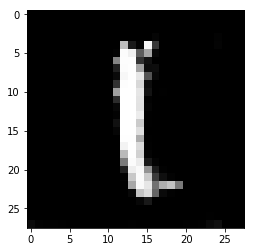

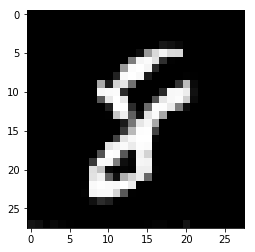

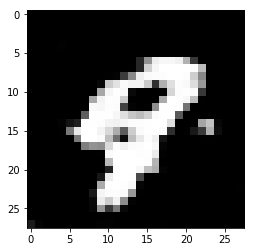

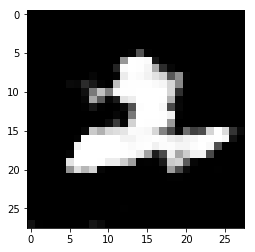

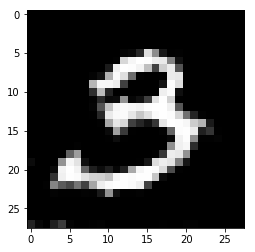

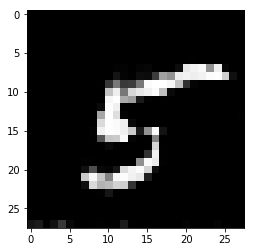

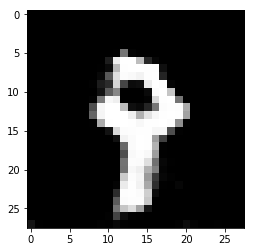

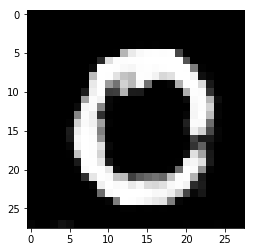

8th iteration gen_loss: 
 2.3254
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8630
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8th iteration gen_loss: 
 2.2936
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7900
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8th iteration gen_loss: 
 2.3187
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7846
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8th iteration gen_loss: 
 2.3080
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7833
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8th iteration gen_loss: 
 2.3185
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7864
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8th iteration gen_loss: 
 2.2951
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7991
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8th iteration gen_loss: 
 2.3179
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8691
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8th iteration gen_lo

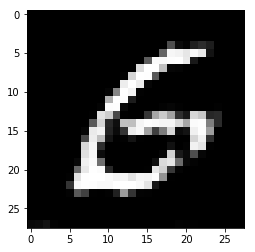

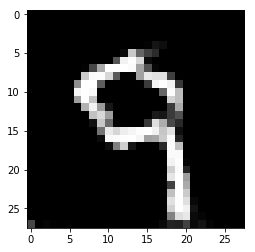

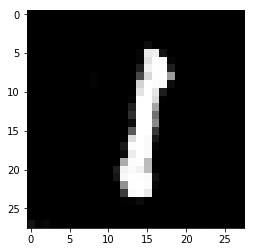

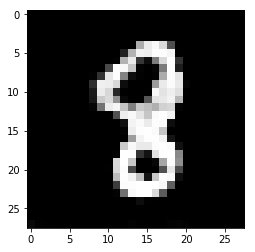

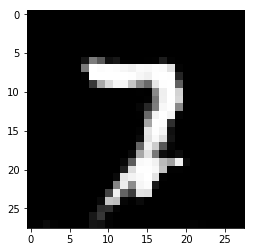

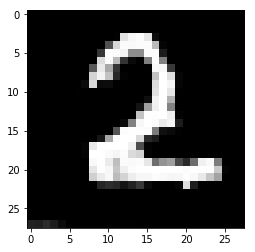

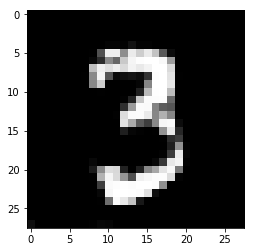

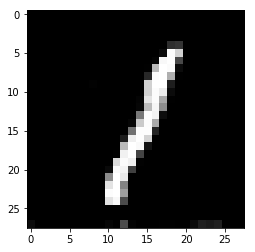

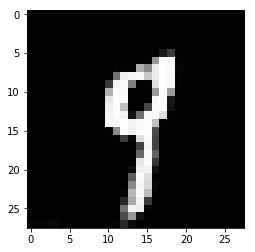

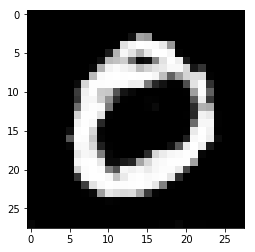

9th iteration gen_loss: 
 2.3267
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7824
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9th iteration gen_loss: 
 2.2941
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7972
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9th iteration gen_loss: 
 2.3343
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7876
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9th iteration gen_loss: 
 2.3358
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7828
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9th iteration gen_loss: 
 2.3217
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7674
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9th iteration gen_loss: 
 2.3504
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8090
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9th iteration gen_loss: 
 2.3168
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7874
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9th iteration gen_lo

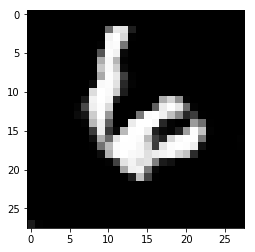

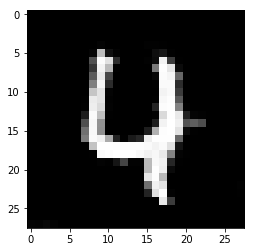

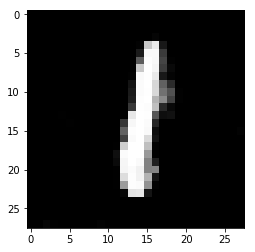

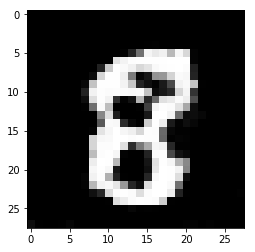

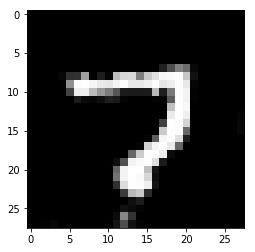

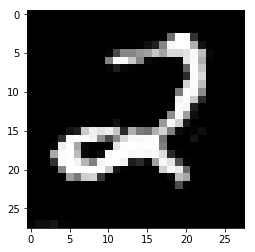

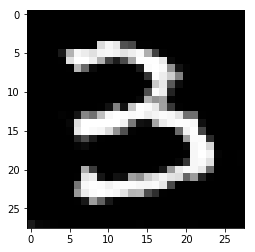

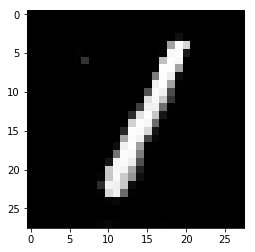

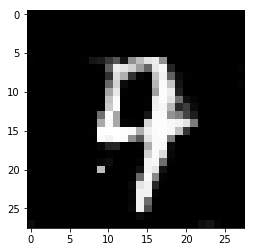

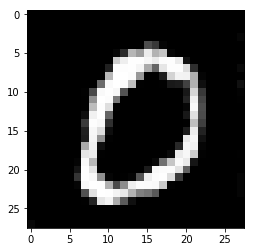

10th iteration gen_loss: 
 2.3304
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7806
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10th iteration gen_loss: 
 2.3052
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7685
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10th iteration gen_loss: 
 2.3268
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7848
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10th iteration gen_loss: 
 2.3402
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7691
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10th iteration gen_loss: 
 2.2711
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7837
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10th iteration gen_loss: 
 2.2914
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7890
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10th iteration gen_loss: 
 2.3397
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7390
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10th iteratio

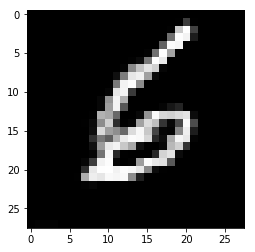

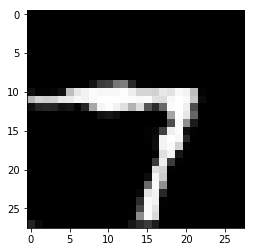

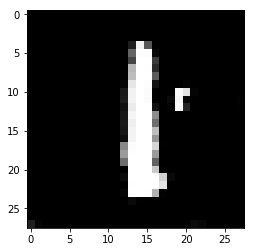

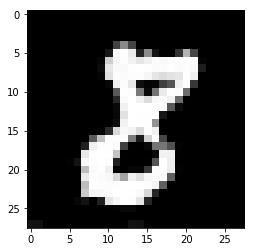

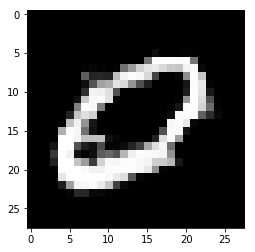

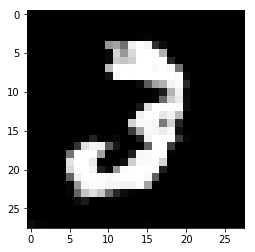

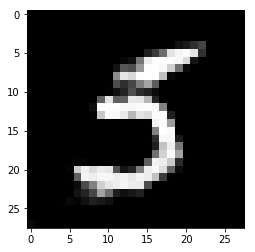

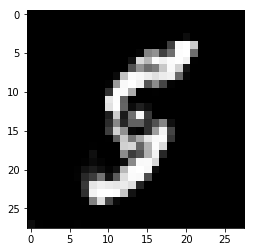

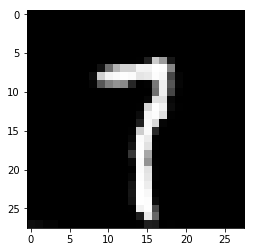

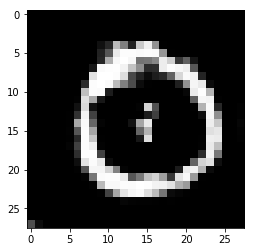

11th iteration gen_loss: 
 2.3764
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7480
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11th iteration gen_loss: 
 2.3431
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7722
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11th iteration gen_loss: 
 2.3610
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8321
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11th iteration gen_loss: 
 2.4147
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7598
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11th iteration gen_loss: 
 2.3660
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7890
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11th iteration gen_loss: 
 2.3522
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7707
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11th iteration gen_loss: 
 2.3368
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8158
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11th iteratio

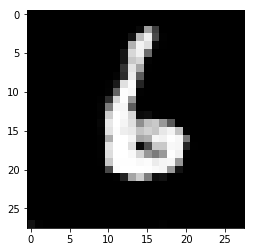

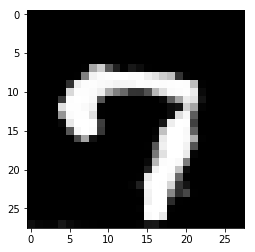

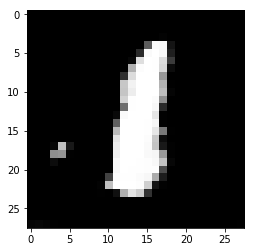

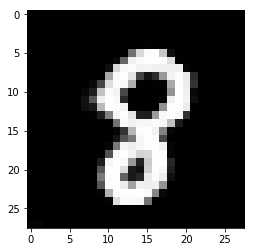

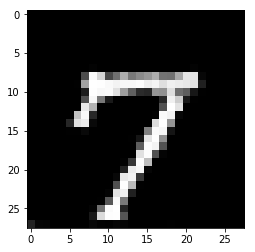

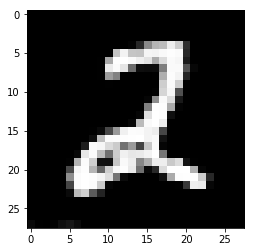

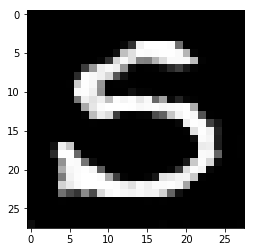

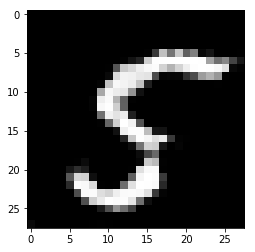

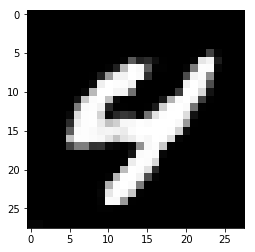

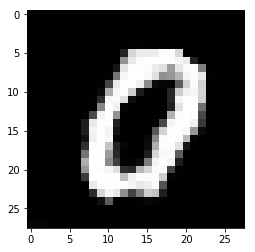

12th iteration gen_loss: 
 2.2902
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8505
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12th iteration gen_loss: 
 2.3707
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7418
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12th iteration gen_loss: 
 2.3378
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8092
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12th iteration gen_loss: 
 2.3275
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7929
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12th iteration gen_loss: 
 2.3329
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7494
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12th iteration gen_loss: 
 2.3399
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7784
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12th iteration gen_loss: 
 2.2911
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7828
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12th iteratio

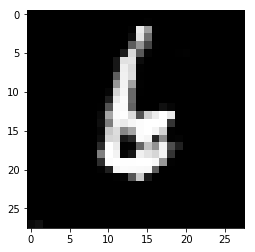

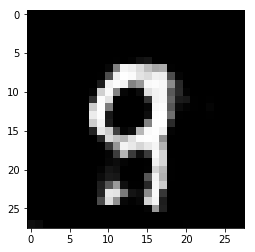

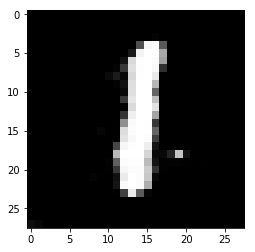

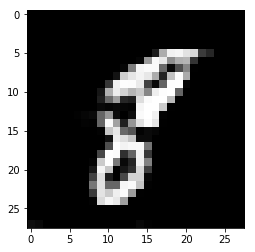

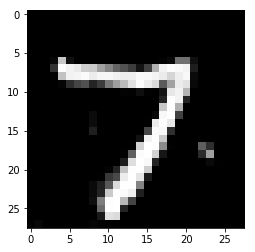

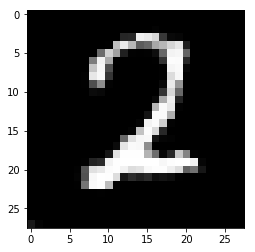

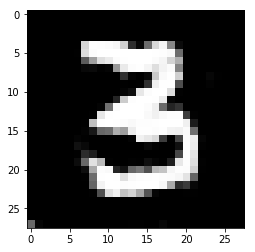

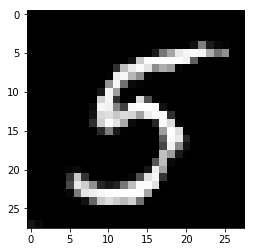

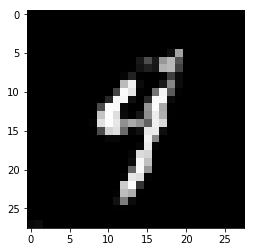

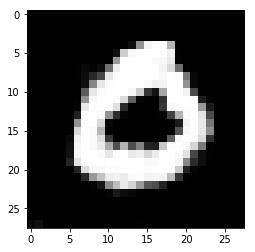

13th iteration gen_loss: 
 2.3408
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8318
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13th iteration gen_loss: 
 2.3265
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7273
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13th iteration gen_loss: 
 2.3568
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8019
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13th iteration gen_loss: 
 2.3442
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7872
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13th iteration gen_loss: 
 2.3052
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7665
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13th iteration gen_loss: 
 2.3347
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7213
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13th iteration gen_loss: 
 2.3922
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7228
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13th iteratio

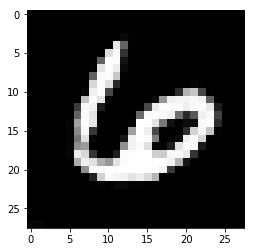

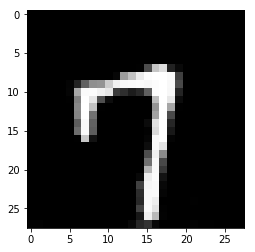

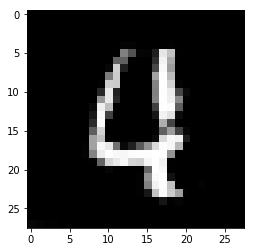

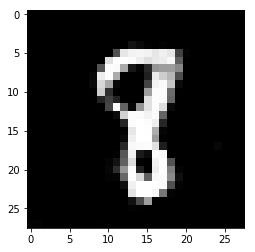

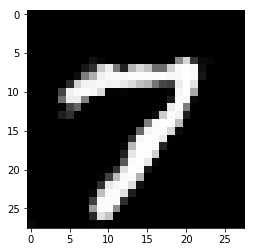

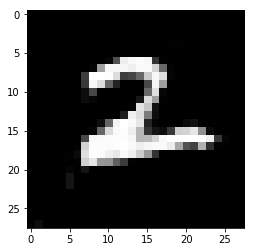

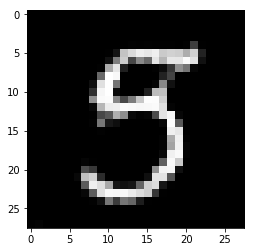

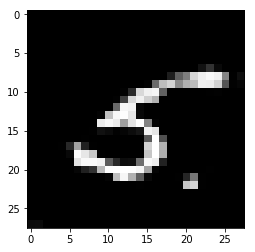

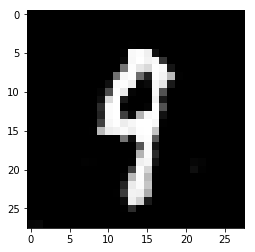

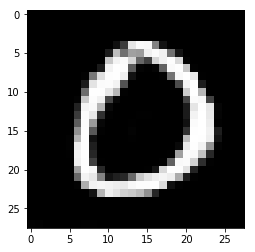

14th iteration gen_loss: 
 2.3844
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7516
[torch.cuda.FloatTensor of size 1 (GPU 0)]

14th iteration gen_loss: 
 2.4066
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7647
[torch.cuda.FloatTensor of size 1 (GPU 0)]

14th iteration gen_loss: 
 2.3153
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7439
[torch.cuda.FloatTensor of size 1 (GPU 0)]

14th iteration gen_loss: 
 2.3793
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7238
[torch.cuda.FloatTensor of size 1 (GPU 0)]

14th iteration gen_loss: 
 2.4119
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7937
[torch.cuda.FloatTensor of size 1 (GPU 0)]

14th iteration gen_loss: 
 2.3541
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7549
[torch.cuda.FloatTensor of size 1 (GPU 0)]

14th iteration gen_loss: 
 2.3635
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7793
[torch.cuda.FloatTensor of size 1 (GPU 0)]

14th iteratio

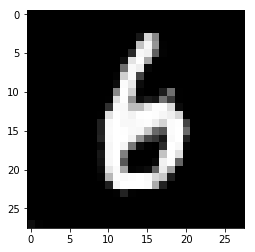

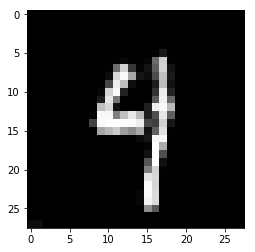

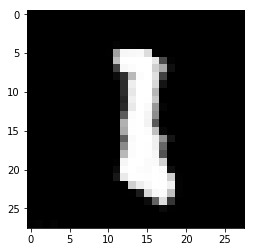

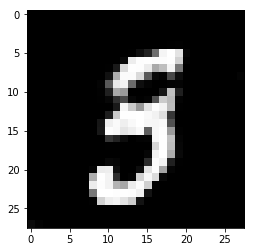

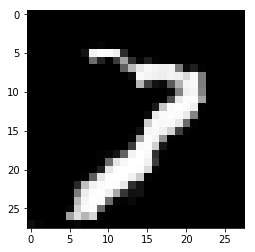

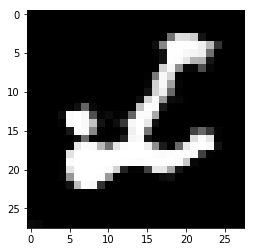

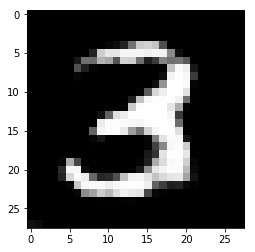

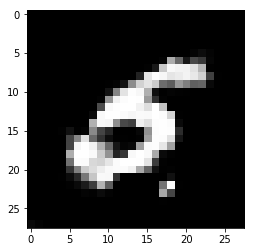

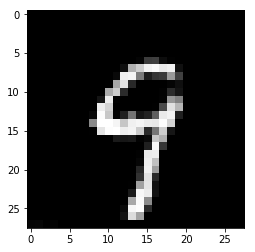

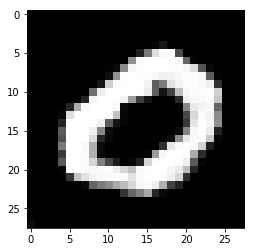

15th iteration gen_loss: 
 2.3728
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7588
[torch.cuda.FloatTensor of size 1 (GPU 0)]

15th iteration gen_loss: 
 2.3647
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7514
[torch.cuda.FloatTensor of size 1 (GPU 0)]

15th iteration gen_loss: 
 2.4205
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7668
[torch.cuda.FloatTensor of size 1 (GPU 0)]

15th iteration gen_loss: 
 2.3927
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6835
[torch.cuda.FloatTensor of size 1 (GPU 0)]

15th iteration gen_loss: 
 2.3380
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7022
[torch.cuda.FloatTensor of size 1 (GPU 0)]

15th iteration gen_loss: 
 2.4049
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6852
[torch.cuda.FloatTensor of size 1 (GPU 0)]

15th iteration gen_loss: 
 2.4222
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7053
[torch.cuda.FloatTensor of size 1 (GPU 0)]

15th iteratio

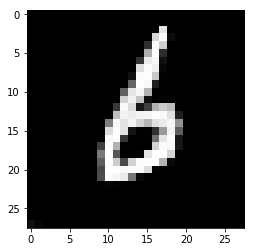

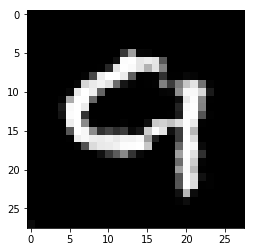

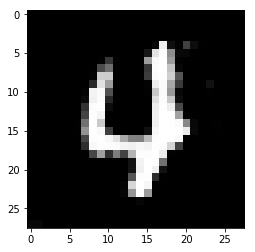

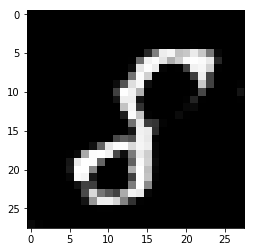

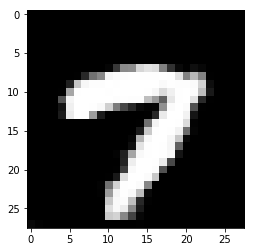

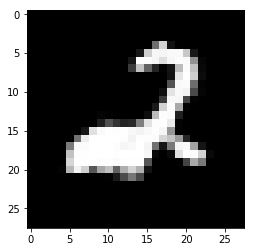

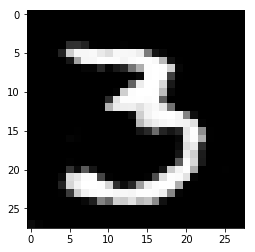

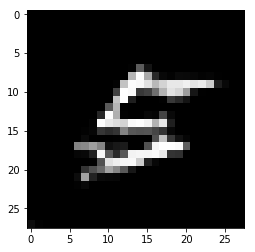

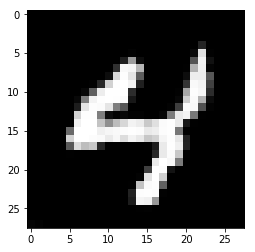

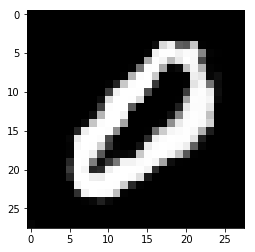

16th iteration gen_loss: 
 2.3668
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6777
[torch.cuda.FloatTensor of size 1 (GPU 0)]

16th iteration gen_loss: 
 2.3972
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7351
[torch.cuda.FloatTensor of size 1 (GPU 0)]

16th iteration gen_loss: 
 2.4020
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7370
[torch.cuda.FloatTensor of size 1 (GPU 0)]

16th iteration gen_loss: 
 2.3485
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7656
[torch.cuda.FloatTensor of size 1 (GPU 0)]

16th iteration gen_loss: 
 2.3920
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8270
[torch.cuda.FloatTensor of size 1 (GPU 0)]

16th iteration gen_loss: 
 2.4223
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7381
[torch.cuda.FloatTensor of size 1 (GPU 0)]

16th iteration gen_loss: 
 2.3359
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7724
[torch.cuda.FloatTensor of size 1 (GPU 0)]

16th iteratio

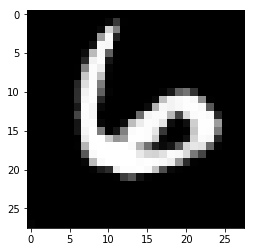

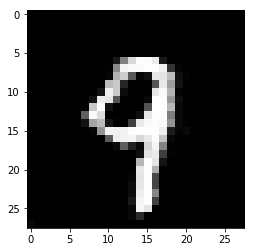

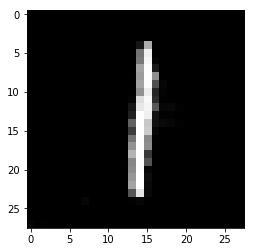

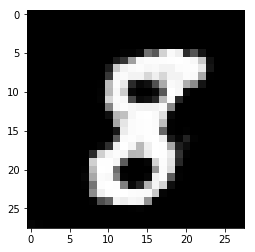

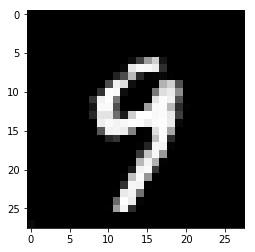

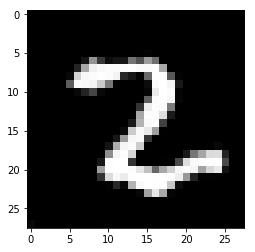

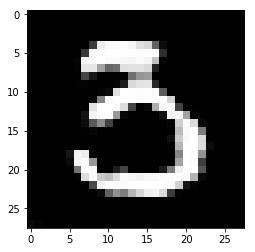

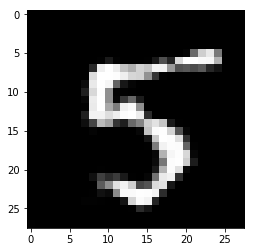

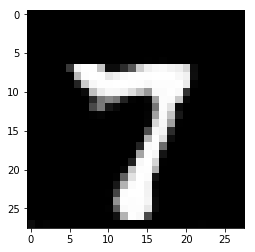

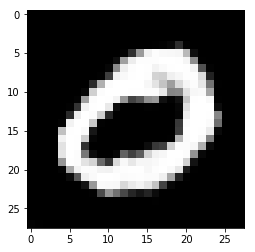

17th iteration gen_loss: 
 2.3683
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7546
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17th iteration gen_loss: 
 2.3832
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7852
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17th iteration gen_loss: 
 2.3676
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8075
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17th iteration gen_loss: 
 2.3931
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7117
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17th iteration gen_loss: 
 2.3872
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7207
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17th iteration gen_loss: 
 2.4107
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7215
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17th iteration gen_loss: 
 2.3908
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6812
[torch.cuda.FloatTensor of size 1 (GPU 0)]

17th iteratio

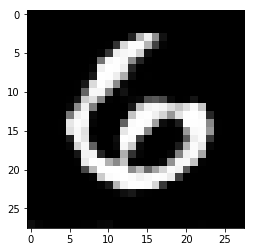

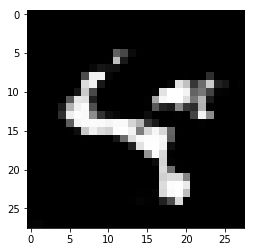

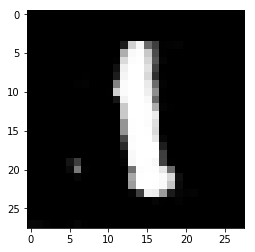

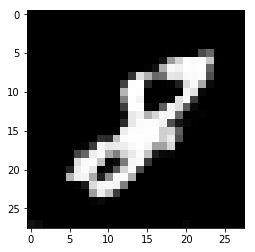

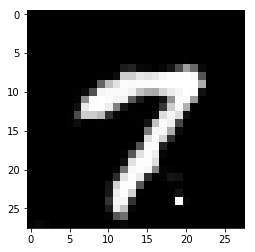

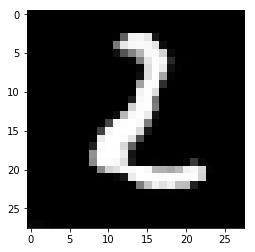

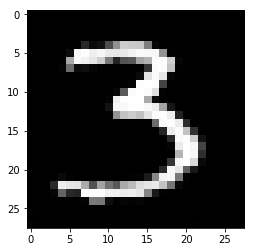

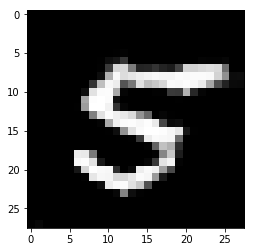

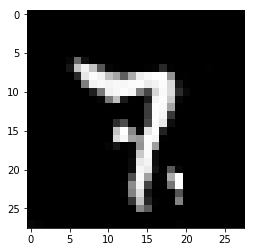

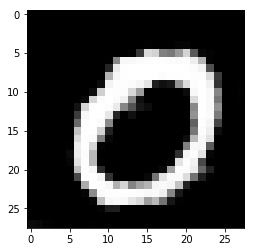

18th iteration gen_loss: 
 2.3063
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7874
[torch.cuda.FloatTensor of size 1 (GPU 0)]

18th iteration gen_loss: 
 2.4569
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6847
[torch.cuda.FloatTensor of size 1 (GPU 0)]

18th iteration gen_loss: 
 2.4011
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6923
[torch.cuda.FloatTensor of size 1 (GPU 0)]

18th iteration gen_loss: 
 2.4529
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6976
[torch.cuda.FloatTensor of size 1 (GPU 0)]

18th iteration gen_loss: 
 2.4951
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7263
[torch.cuda.FloatTensor of size 1 (GPU 0)]

18th iteration gen_loss: 
 2.3608
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7738
[torch.cuda.FloatTensor of size 1 (GPU 0)]

18th iteration gen_loss: 
 2.3841
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7894
[torch.cuda.FloatTensor of size 1 (GPU 0)]

18th iteratio

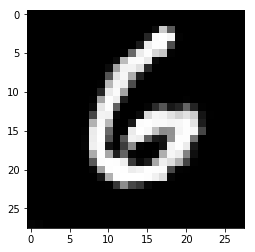

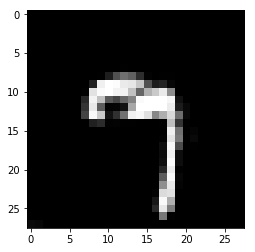

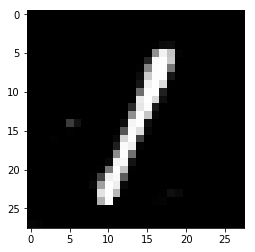

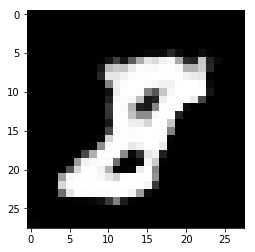

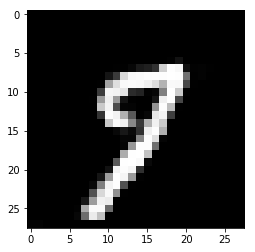

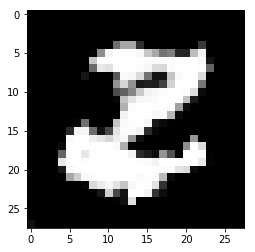

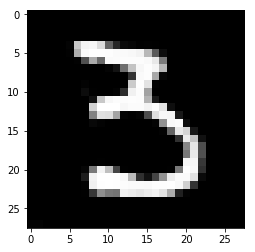

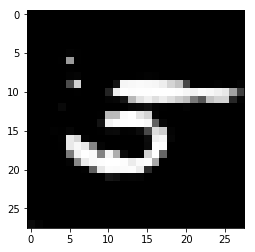

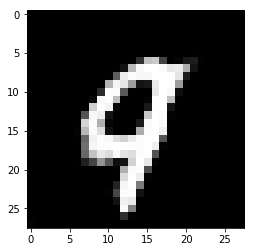

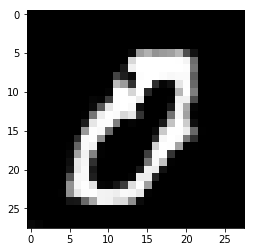

19th iteration gen_loss: 
 2.3543
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6900
[torch.cuda.FloatTensor of size 1 (GPU 0)]

19th iteration gen_loss: 
 2.3601
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7331
[torch.cuda.FloatTensor of size 1 (GPU 0)]

19th iteration gen_loss: 
 2.3863
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6984
[torch.cuda.FloatTensor of size 1 (GPU 0)]

19th iteration gen_loss: 
 2.4466
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.8395
[torch.cuda.FloatTensor of size 1 (GPU 0)]

19th iteration gen_loss: 
 2.3559
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7163
[torch.cuda.FloatTensor of size 1 (GPU 0)]

19th iteration gen_loss: 
 2.4262
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7252
[torch.cuda.FloatTensor of size 1 (GPU 0)]

19th iteration gen_loss: 
 2.3744
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6755
[torch.cuda.FloatTensor of size 1 (GPU 0)]

19th iteratio

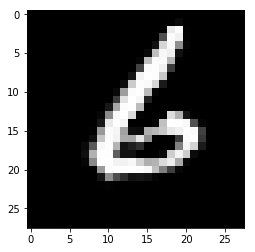

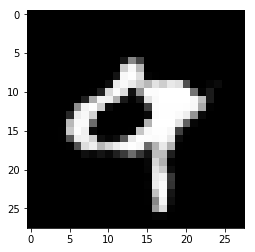

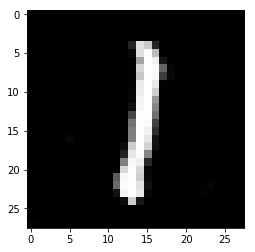

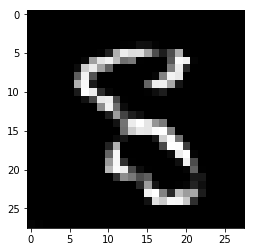

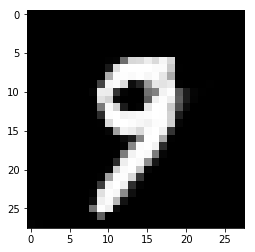

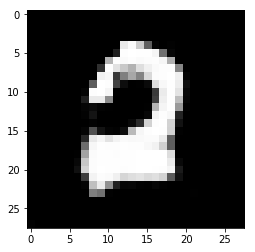

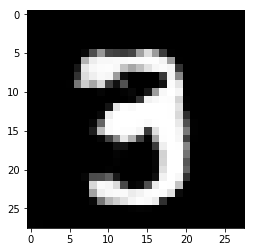

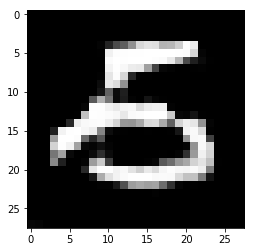

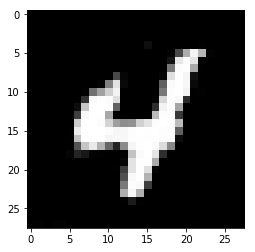

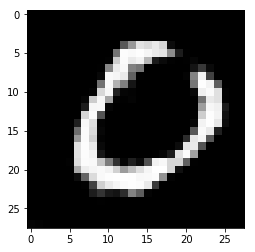

20th iteration gen_loss: 
 2.4865
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7834
[torch.cuda.FloatTensor of size 1 (GPU 0)]

20th iteration gen_loss: 
 2.3983
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7434
[torch.cuda.FloatTensor of size 1 (GPU 0)]

20th iteration gen_loss: 
 2.3983
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6813
[torch.cuda.FloatTensor of size 1 (GPU 0)]

20th iteration gen_loss: 
 2.4299
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6282
[torch.cuda.FloatTensor of size 1 (GPU 0)]

20th iteration gen_loss: 
 2.4032
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7101
[torch.cuda.FloatTensor of size 1 (GPU 0)]

20th iteration gen_loss: 
 2.3719
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7231
[torch.cuda.FloatTensor of size 1 (GPU 0)]

20th iteration gen_loss: 
 2.4484
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6978
[torch.cuda.FloatTensor of size 1 (GPU 0)]

20th iteratio

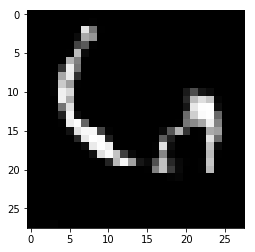

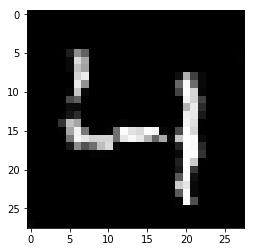

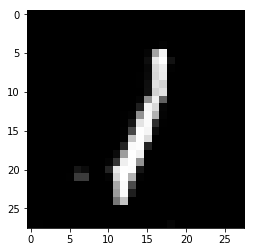

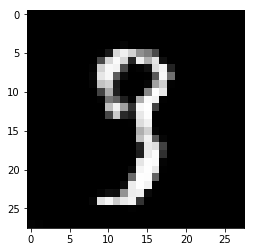

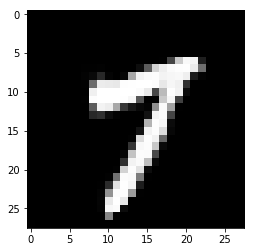

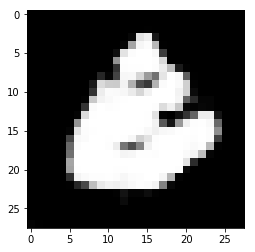

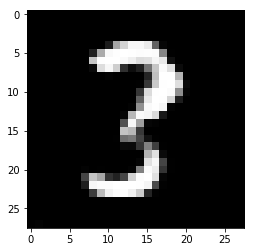

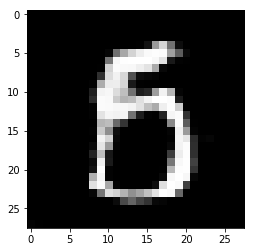

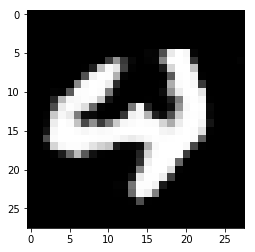

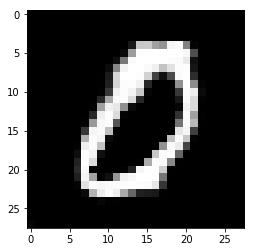

21th iteration gen_loss: 
 2.3941
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7292
[torch.cuda.FloatTensor of size 1 (GPU 0)]

21th iteration gen_loss: 
 2.4562
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6757
[torch.cuda.FloatTensor of size 1 (GPU 0)]

21th iteration gen_loss: 
 2.4279
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6947
[torch.cuda.FloatTensor of size 1 (GPU 0)]

21th iteration gen_loss: 
 2.4500
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7056
[torch.cuda.FloatTensor of size 1 (GPU 0)]

21th iteration gen_loss: 
 2.4525
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6885
[torch.cuda.FloatTensor of size 1 (GPU 0)]

21th iteration gen_loss: 
 2.3191
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7134
[torch.cuda.FloatTensor of size 1 (GPU 0)]

21th iteration gen_loss: 
 2.4198
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7148
[torch.cuda.FloatTensor of size 1 (GPU 0)]

21th iteratio

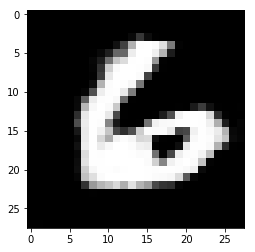

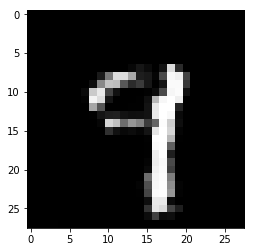

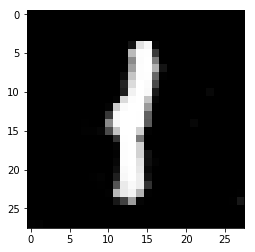

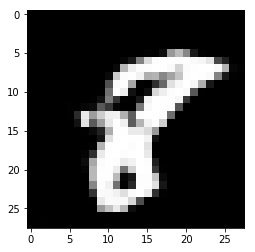

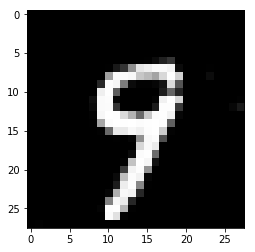

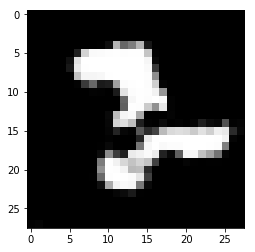

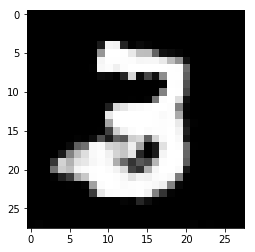

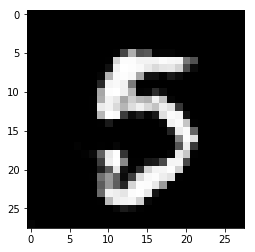

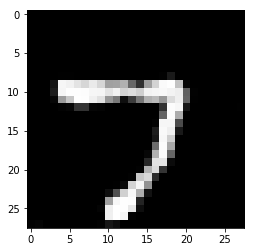

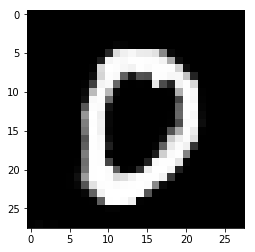

22th iteration gen_loss: 
 2.4024
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6862
[torch.cuda.FloatTensor of size 1 (GPU 0)]

22th iteration gen_loss: 
 2.4876
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7137
[torch.cuda.FloatTensor of size 1 (GPU 0)]

22th iteration gen_loss: 
 2.4162
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6979
[torch.cuda.FloatTensor of size 1 (GPU 0)]

22th iteration gen_loss: 
 2.4745
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6368
[torch.cuda.FloatTensor of size 1 (GPU 0)]

22th iteration gen_loss: 
 2.4113
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6393
[torch.cuda.FloatTensor of size 1 (GPU 0)]

22th iteration gen_loss: 
 2.4656
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6051
[torch.cuda.FloatTensor of size 1 (GPU 0)]

22th iteration gen_loss: 
 2.3921
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6582
[torch.cuda.FloatTensor of size 1 (GPU 0)]

22th iteratio

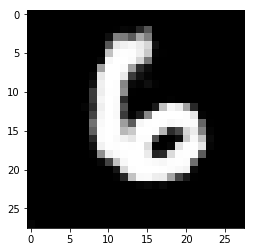

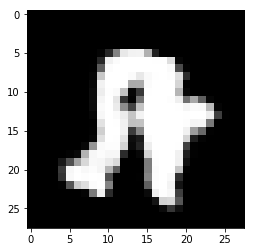

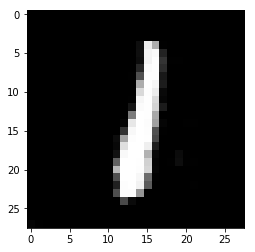

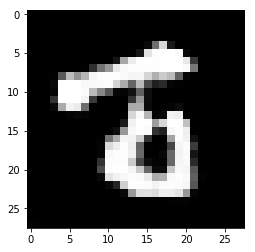

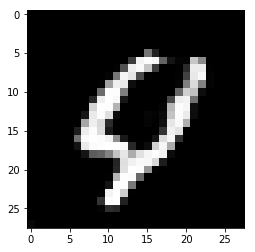

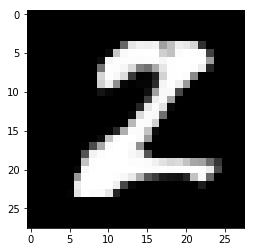

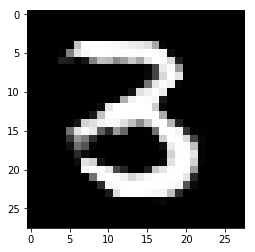

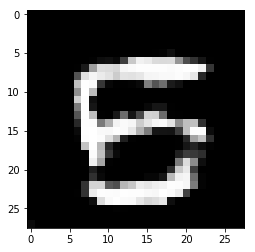

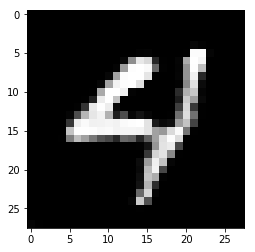

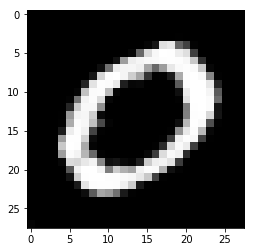

23th iteration gen_loss: 
 2.3822
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7049
[torch.cuda.FloatTensor of size 1 (GPU 0)]

23th iteration gen_loss: 
 2.4011
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7031
[torch.cuda.FloatTensor of size 1 (GPU 0)]

23th iteration gen_loss: 
 2.3656
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7501
[torch.cuda.FloatTensor of size 1 (GPU 0)]

23th iteration gen_loss: 
 2.3384
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6901
[torch.cuda.FloatTensor of size 1 (GPU 0)]

23th iteration gen_loss: 
 2.4120
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7220
[torch.cuda.FloatTensor of size 1 (GPU 0)]

23th iteration gen_loss: 
 2.3393
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7897
[torch.cuda.FloatTensor of size 1 (GPU 0)]

23th iteration gen_loss: 
 2.3273
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7652
[torch.cuda.FloatTensor of size 1 (GPU 0)]

23th iteratio

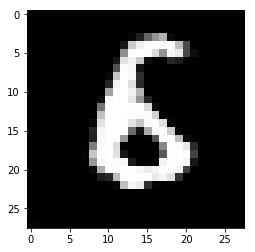

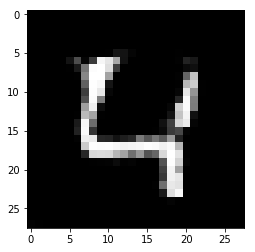

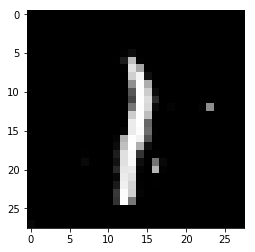

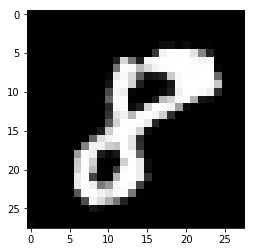

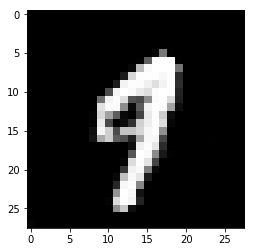

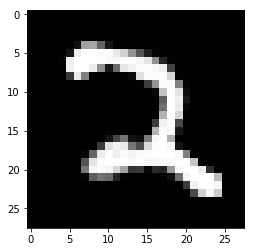

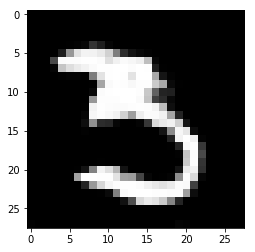

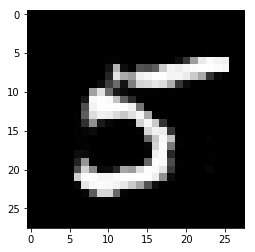

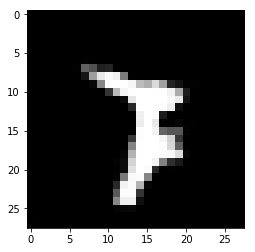

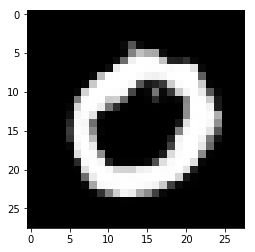

24th iteration gen_loss: 
 2.4003
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6394
[torch.cuda.FloatTensor of size 1 (GPU 0)]

24th iteration gen_loss: 
 2.4956
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7023
[torch.cuda.FloatTensor of size 1 (GPU 0)]

24th iteration gen_loss: 
 2.4592
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6534
[torch.cuda.FloatTensor of size 1 (GPU 0)]

24th iteration gen_loss: 
 2.4987
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6737
[torch.cuda.FloatTensor of size 1 (GPU 0)]

24th iteration gen_loss: 
 2.4100
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6258
[torch.cuda.FloatTensor of size 1 (GPU 0)]

24th iteration gen_loss: 
 2.4021
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6943
[torch.cuda.FloatTensor of size 1 (GPU 0)]

24th iteration gen_loss: 
 2.4530
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6109
[torch.cuda.FloatTensor of size 1 (GPU 0)]

24th iteratio

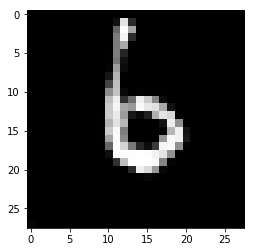

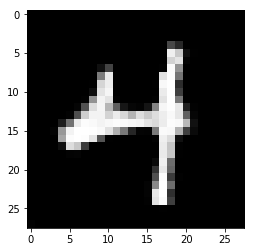

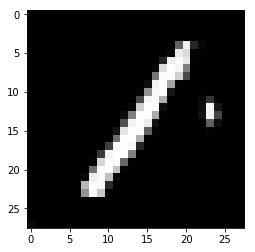

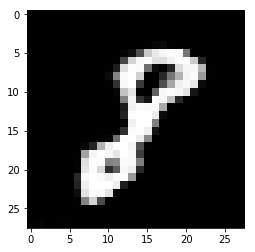

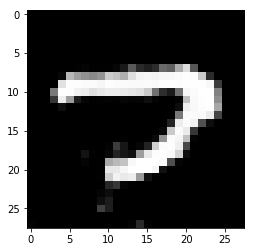

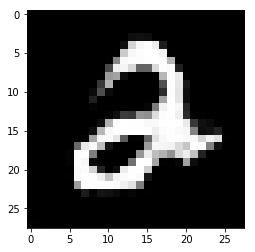

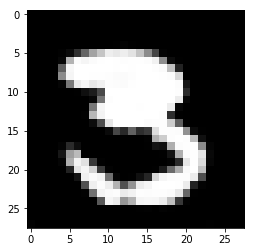

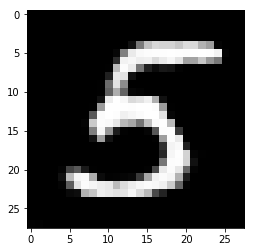

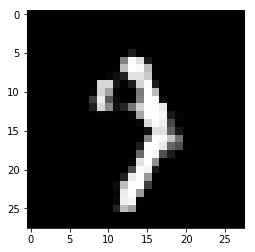

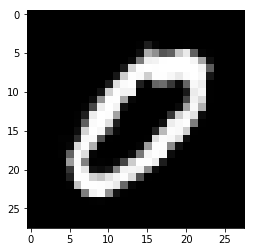

25th iteration gen_loss: 
 2.5057
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6778
[torch.cuda.FloatTensor of size 1 (GPU 0)]

25th iteration gen_loss: 
 2.3319
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7262
[torch.cuda.FloatTensor of size 1 (GPU 0)]

25th iteration gen_loss: 
 2.4953
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6970
[torch.cuda.FloatTensor of size 1 (GPU 0)]

25th iteration gen_loss: 
 2.4423
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7939
[torch.cuda.FloatTensor of size 1 (GPU 0)]

25th iteration gen_loss: 
 2.4542
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7475
[torch.cuda.FloatTensor of size 1 (GPU 0)]

25th iteration gen_loss: 
 2.4321
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7306
[torch.cuda.FloatTensor of size 1 (GPU 0)]

25th iteration gen_loss: 
 2.5311
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6905
[torch.cuda.FloatTensor of size 1 (GPU 0)]

25th iteratio

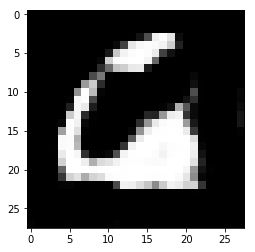

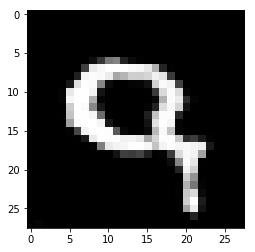

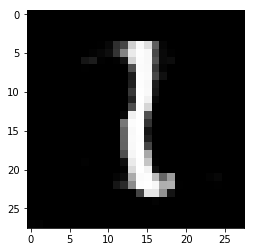

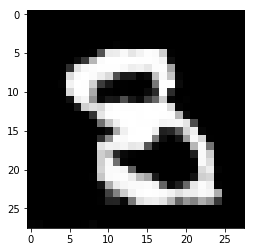

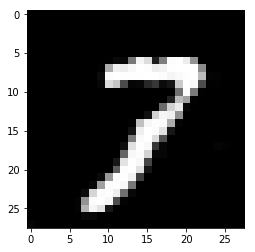

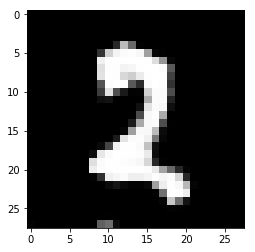

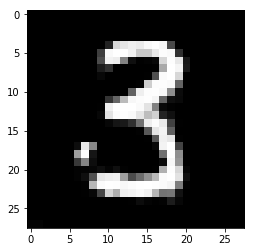

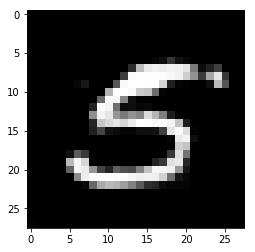

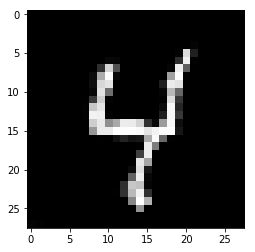

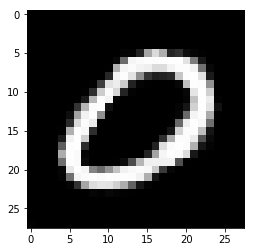

26th iteration gen_loss: 
 2.5202
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6784
[torch.cuda.FloatTensor of size 1 (GPU 0)]

26th iteration gen_loss: 
 2.4807
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6943
[torch.cuda.FloatTensor of size 1 (GPU 0)]

26th iteration gen_loss: 
 2.4244
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5759
[torch.cuda.FloatTensor of size 1 (GPU 0)]

26th iteration gen_loss: 
 2.5210
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6426
[torch.cuda.FloatTensor of size 1 (GPU 0)]

26th iteration gen_loss: 
 2.4677
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7053
[torch.cuda.FloatTensor of size 1 (GPU 0)]

26th iteration gen_loss: 
 2.4250
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6439
[torch.cuda.FloatTensor of size 1 (GPU 0)]

26th iteration gen_loss: 
 2.4136
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6696
[torch.cuda.FloatTensor of size 1 (GPU 0)]

26th iteratio

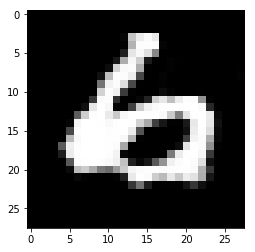

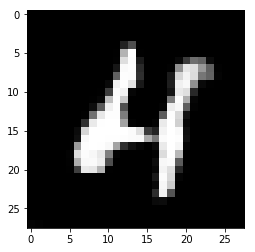

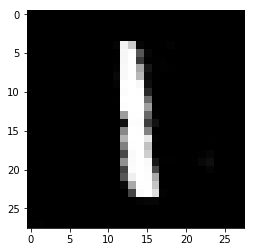

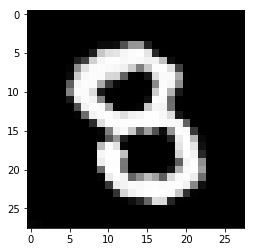

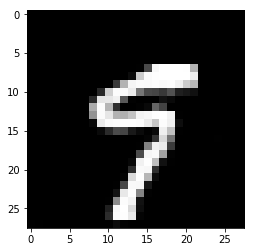

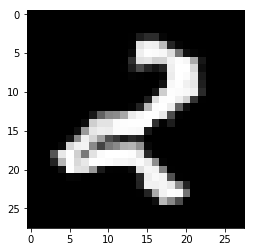

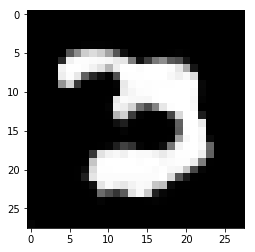

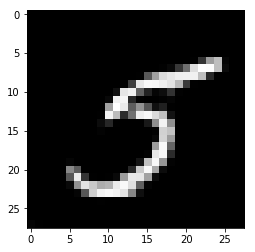

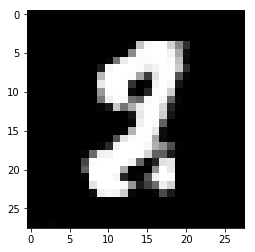

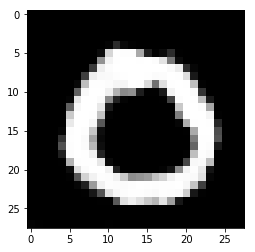

27th iteration gen_loss: 
 2.4828
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6040
[torch.cuda.FloatTensor of size 1 (GPU 0)]

27th iteration gen_loss: 
 2.4048
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6073
[torch.cuda.FloatTensor of size 1 (GPU 0)]

27th iteration gen_loss: 
 2.4693
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6207
[torch.cuda.FloatTensor of size 1 (GPU 0)]

27th iteration gen_loss: 
 2.5448
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7099
[torch.cuda.FloatTensor of size 1 (GPU 0)]

27th iteration gen_loss: 
 2.5240
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6325
[torch.cuda.FloatTensor of size 1 (GPU 0)]

27th iteration gen_loss: 
 2.5013
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7051
[torch.cuda.FloatTensor of size 1 (GPU 0)]

27th iteration gen_loss: 
 2.4724
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6797
[torch.cuda.FloatTensor of size 1 (GPU 0)]

27th iteratio

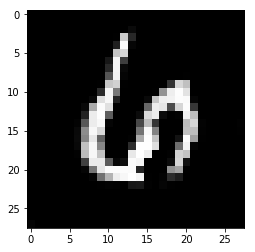

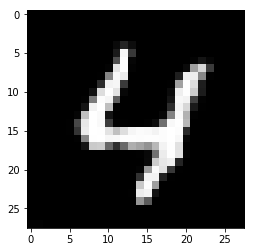

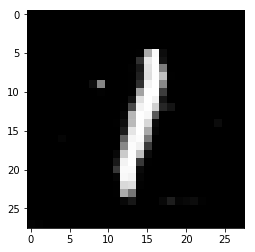

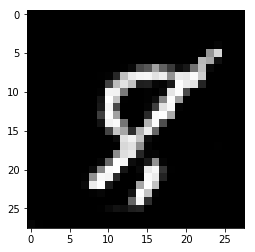

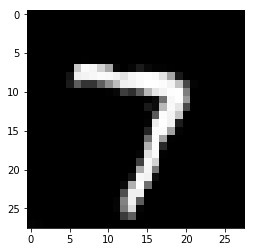

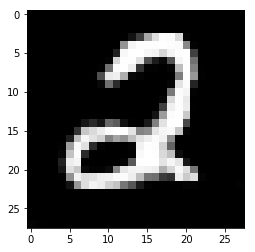

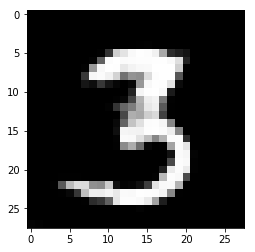

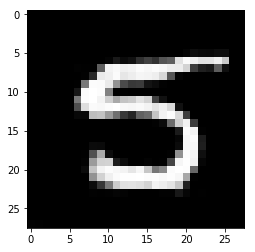

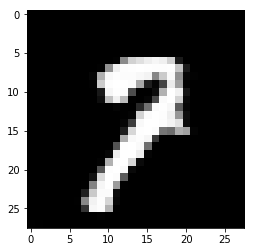

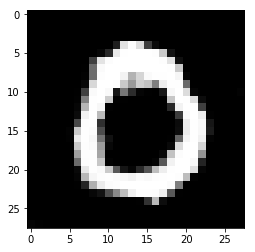

28th iteration gen_loss: 
 2.4864
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6518
[torch.cuda.FloatTensor of size 1 (GPU 0)]

28th iteration gen_loss: 
 2.6926
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6570
[torch.cuda.FloatTensor of size 1 (GPU 0)]

28th iteration gen_loss: 
 2.4666
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5843
[torch.cuda.FloatTensor of size 1 (GPU 0)]

28th iteration gen_loss: 
 2.6040
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6666
[torch.cuda.FloatTensor of size 1 (GPU 0)]

28th iteration gen_loss: 
 2.6023
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5917
[torch.cuda.FloatTensor of size 1 (GPU 0)]

28th iteration gen_loss: 
 2.4669
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7014
[torch.cuda.FloatTensor of size 1 (GPU 0)]

28th iteration gen_loss: 
 2.5579
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6679
[torch.cuda.FloatTensor of size 1 (GPU 0)]

28th iteratio

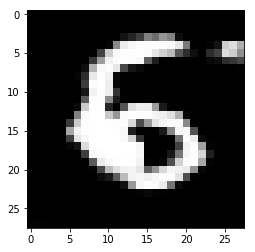

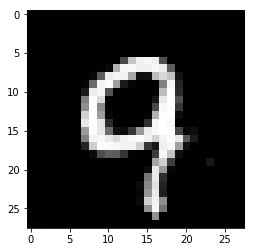

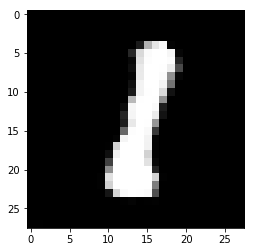

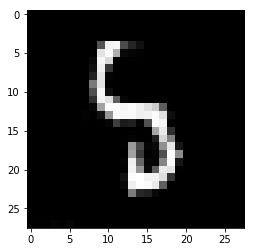

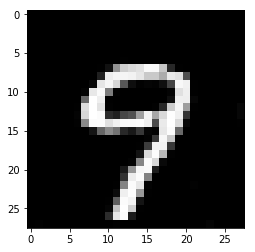

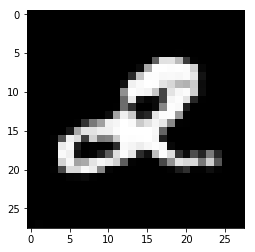

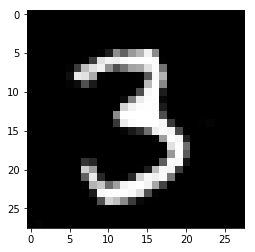

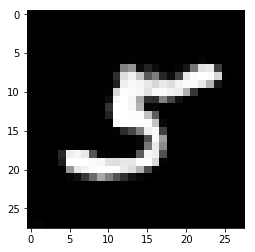

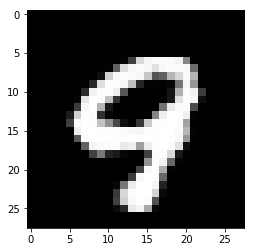

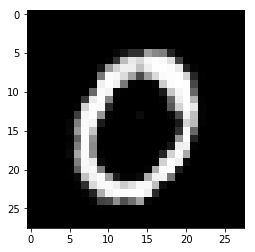

29th iteration gen_loss: 
 2.4468
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5943
[torch.cuda.FloatTensor of size 1 (GPU 0)]

29th iteration gen_loss: 
 2.5425
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5775
[torch.cuda.FloatTensor of size 1 (GPU 0)]

29th iteration gen_loss: 
 2.4154
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6816
[torch.cuda.FloatTensor of size 1 (GPU 0)]

29th iteration gen_loss: 
 2.4959
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7491
[torch.cuda.FloatTensor of size 1 (GPU 0)]

29th iteration gen_loss: 
 2.4576
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6457
[torch.cuda.FloatTensor of size 1 (GPU 0)]

29th iteration gen_loss: 
 2.4752
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6759
[torch.cuda.FloatTensor of size 1 (GPU 0)]

29th iteration gen_loss: 
 2.3925
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6438
[torch.cuda.FloatTensor of size 1 (GPU 0)]

29th iteratio

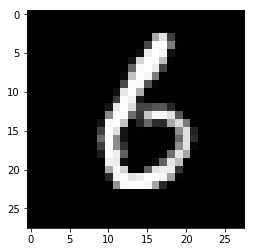

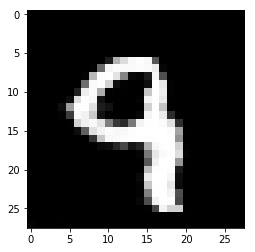

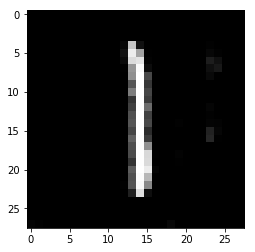

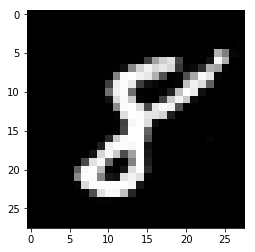

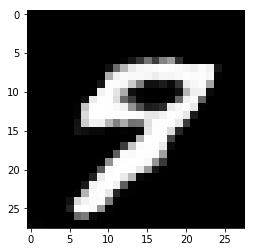

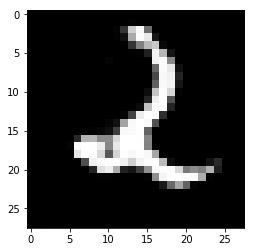

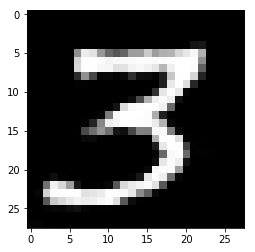

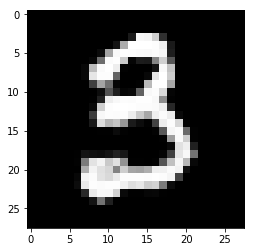

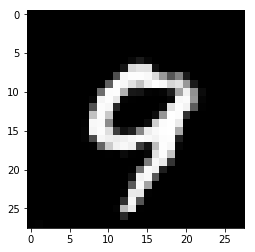

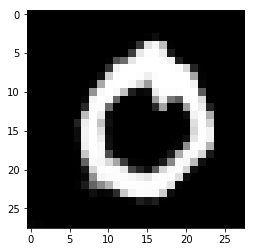

30th iteration gen_loss: 
 2.3989
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6659
[torch.cuda.FloatTensor of size 1 (GPU 0)]

30th iteration gen_loss: 
 2.4318
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6783
[torch.cuda.FloatTensor of size 1 (GPU 0)]

30th iteration gen_loss: 
 2.4140
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6484
[torch.cuda.FloatTensor of size 1 (GPU 0)]

30th iteration gen_loss: 
 2.4569
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6255
[torch.cuda.FloatTensor of size 1 (GPU 0)]

30th iteration gen_loss: 
 2.5571
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6891
[torch.cuda.FloatTensor of size 1 (GPU 0)]

30th iteration gen_loss: 
 2.5194
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6985
[torch.cuda.FloatTensor of size 1 (GPU 0)]

30th iteration gen_loss: 
 2.5396
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6107
[torch.cuda.FloatTensor of size 1 (GPU 0)]

30th iteratio

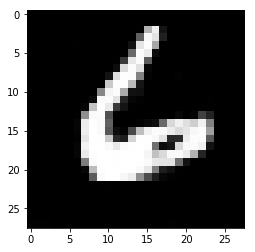

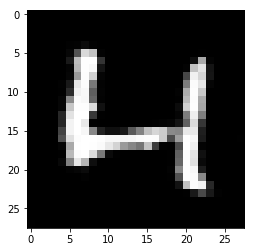

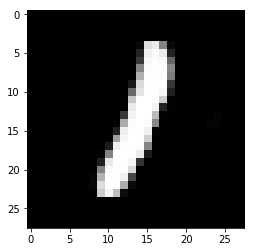

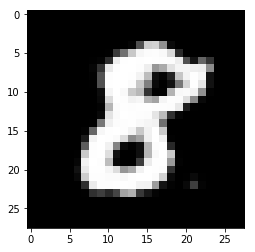

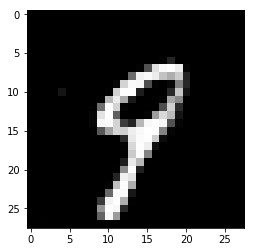

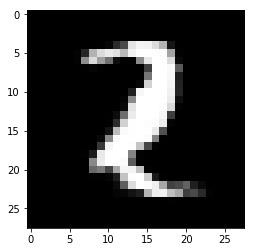

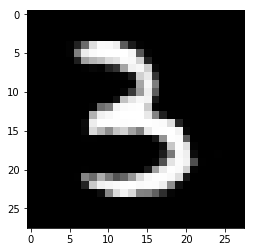

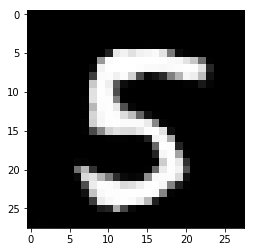

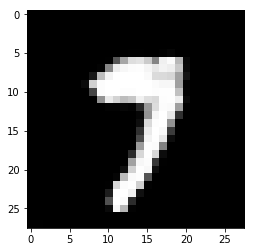

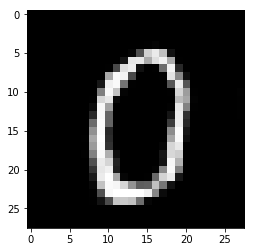

31th iteration gen_loss: 
 2.5746
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6058
[torch.cuda.FloatTensor of size 1 (GPU 0)]

31th iteration gen_loss: 
 2.4994
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6843
[torch.cuda.FloatTensor of size 1 (GPU 0)]

31th iteration gen_loss: 
 2.4638
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6562
[torch.cuda.FloatTensor of size 1 (GPU 0)]

31th iteration gen_loss: 
 2.5496
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6675
[torch.cuda.FloatTensor of size 1 (GPU 0)]

31th iteration gen_loss: 
 2.5045
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7157
[torch.cuda.FloatTensor of size 1 (GPU 0)]

31th iteration gen_loss: 
 2.5071
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7012
[torch.cuda.FloatTensor of size 1 (GPU 0)]

31th iteration gen_loss: 
 2.5512
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6853
[torch.cuda.FloatTensor of size 1 (GPU 0)]

31th iteratio

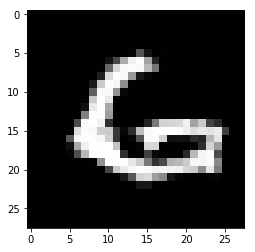

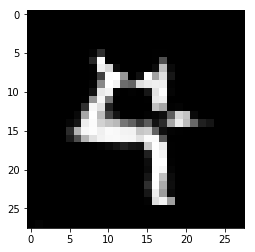

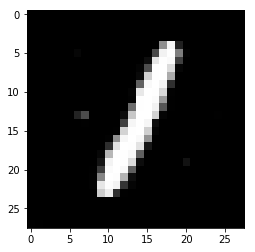

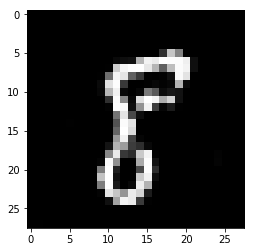

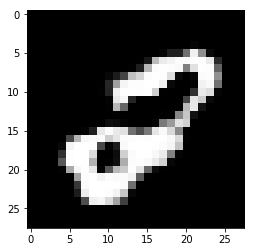

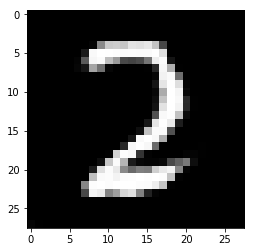

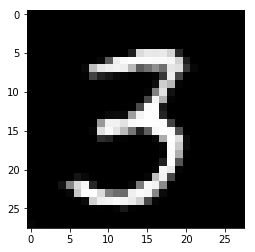

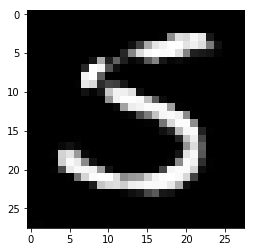

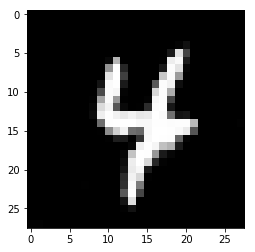

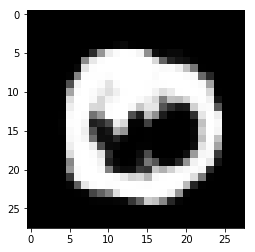

32th iteration gen_loss: 
 2.4339
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6779
[torch.cuda.FloatTensor of size 1 (GPU 0)]

32th iteration gen_loss: 
 2.5345
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6642
[torch.cuda.FloatTensor of size 1 (GPU 0)]

32th iteration gen_loss: 
 2.5129
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5816
[torch.cuda.FloatTensor of size 1 (GPU 0)]

32th iteration gen_loss: 
 2.3963
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6616
[torch.cuda.FloatTensor of size 1 (GPU 0)]

32th iteration gen_loss: 
 2.5060
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5882
[torch.cuda.FloatTensor of size 1 (GPU 0)]

32th iteration gen_loss: 
 2.4540
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6512
[torch.cuda.FloatTensor of size 1 (GPU 0)]

32th iteration gen_loss: 
 2.5017
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7188
[torch.cuda.FloatTensor of size 1 (GPU 0)]

32th iteratio

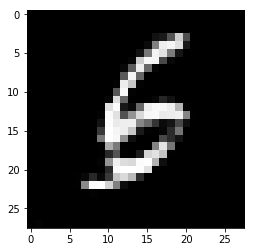

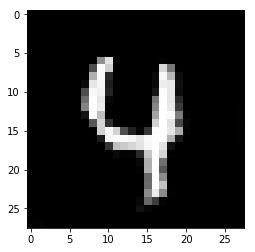

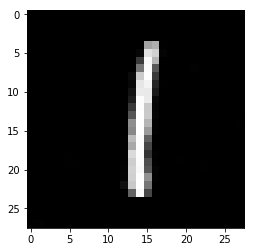

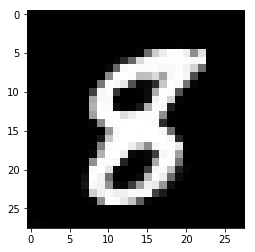

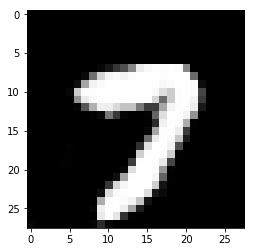

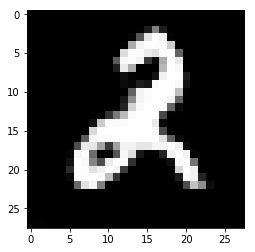

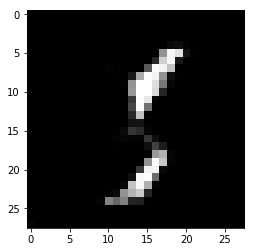

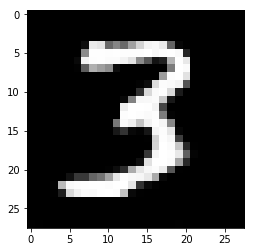

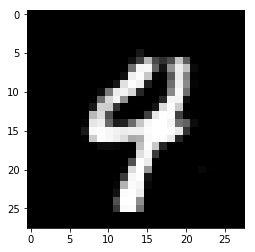

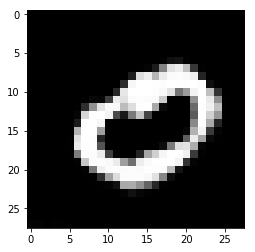

33th iteration gen_loss: 
 2.4039
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6577
[torch.cuda.FloatTensor of size 1 (GPU 0)]

33th iteration gen_loss: 
 2.4858
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6381
[torch.cuda.FloatTensor of size 1 (GPU 0)]

33th iteration gen_loss: 
 2.7029
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6487
[torch.cuda.FloatTensor of size 1 (GPU 0)]

33th iteration gen_loss: 
 2.5298
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5768
[torch.cuda.FloatTensor of size 1 (GPU 0)]

33th iteration gen_loss: 
 2.5842
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6138
[torch.cuda.FloatTensor of size 1 (GPU 0)]

33th iteration gen_loss: 
 2.5950
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5334
[torch.cuda.FloatTensor of size 1 (GPU 0)]

33th iteration gen_loss: 
 2.7662
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5629
[torch.cuda.FloatTensor of size 1 (GPU 0)]

33th iteratio

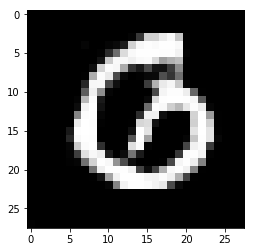

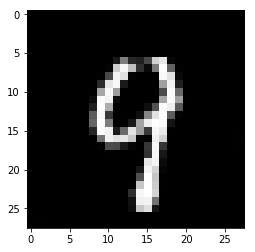

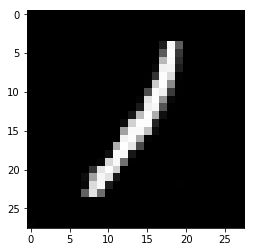

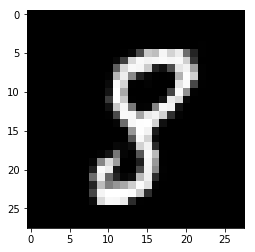

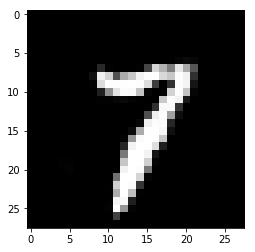

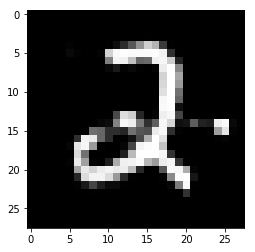

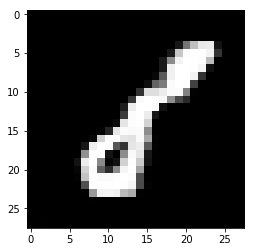

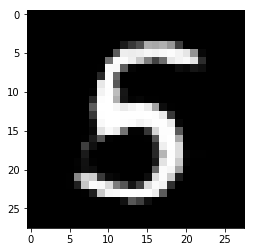

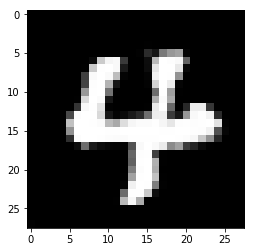

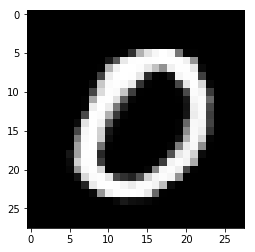

34th iteration gen_loss: 
 2.5168
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6176
[torch.cuda.FloatTensor of size 1 (GPU 0)]

34th iteration gen_loss: 
 2.4229
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6220
[torch.cuda.FloatTensor of size 1 (GPU 0)]

34th iteration gen_loss: 
 2.4883
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6752
[torch.cuda.FloatTensor of size 1 (GPU 0)]

34th iteration gen_loss: 
 2.4729
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6146
[torch.cuda.FloatTensor of size 1 (GPU 0)]

34th iteration gen_loss: 
 2.5001
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6008
[torch.cuda.FloatTensor of size 1 (GPU 0)]

34th iteration gen_loss: 
 2.5888
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7105
[torch.cuda.FloatTensor of size 1 (GPU 0)]

34th iteration gen_loss: 
 2.6404
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6268
[torch.cuda.FloatTensor of size 1 (GPU 0)]

34th iteratio

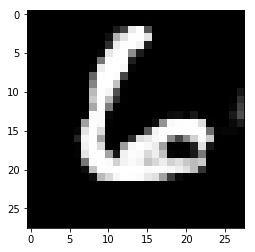

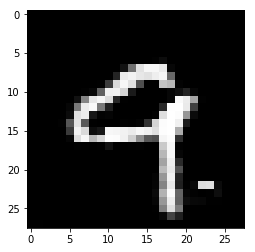

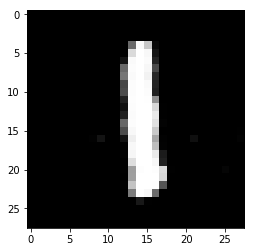

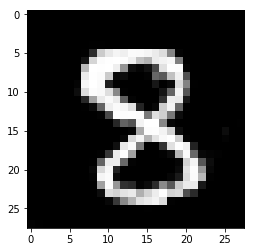

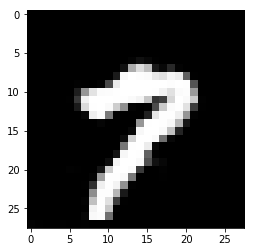

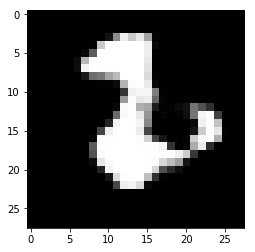

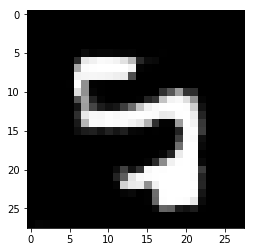

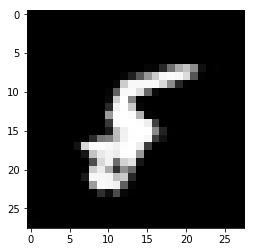

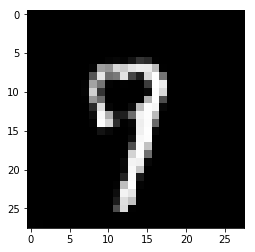

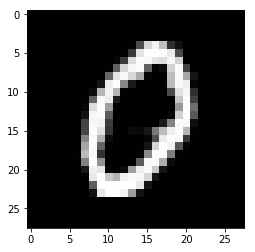

35th iteration gen_loss: 
 2.6426
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6408
[torch.cuda.FloatTensor of size 1 (GPU 0)]

35th iteration gen_loss: 
 2.6767
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5883
[torch.cuda.FloatTensor of size 1 (GPU 0)]

35th iteration gen_loss: 
 2.5222
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6206
[torch.cuda.FloatTensor of size 1 (GPU 0)]

35th iteration gen_loss: 
 2.5762
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5668
[torch.cuda.FloatTensor of size 1 (GPU 0)]

35th iteration gen_loss: 
 2.5904
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4710
[torch.cuda.FloatTensor of size 1 (GPU 0)]

35th iteration gen_loss: 
 2.5210
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6535
[torch.cuda.FloatTensor of size 1 (GPU 0)]

35th iteration gen_loss: 
 2.6188
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5749
[torch.cuda.FloatTensor of size 1 (GPU 0)]

35th iteratio

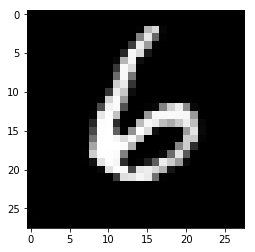

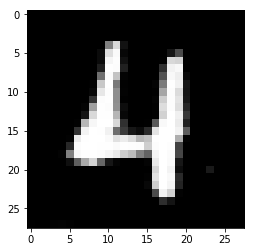

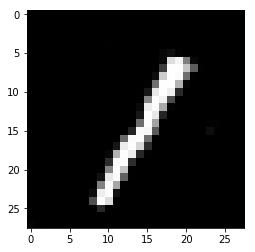

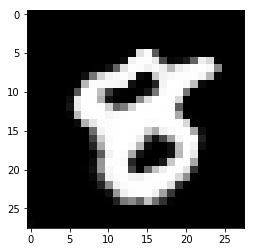

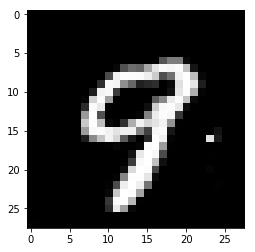

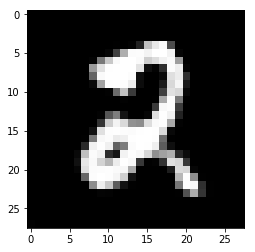

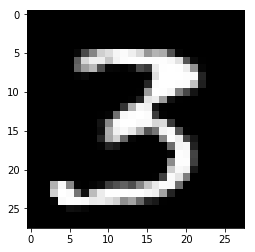

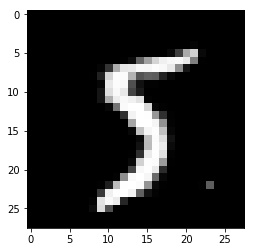

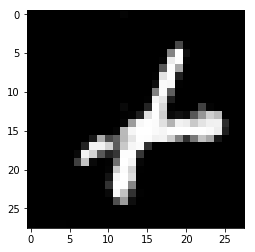

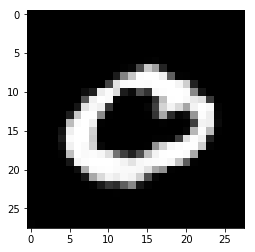

36th iteration gen_loss: 
 2.5279
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6162
[torch.cuda.FloatTensor of size 1 (GPU 0)]

36th iteration gen_loss: 
 2.5629
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5538
[torch.cuda.FloatTensor of size 1 (GPU 0)]

36th iteration gen_loss: 
 2.4794
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6995
[torch.cuda.FloatTensor of size 1 (GPU 0)]

36th iteration gen_loss: 
 2.6343
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6174
[torch.cuda.FloatTensor of size 1 (GPU 0)]

36th iteration gen_loss: 
 2.4813
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6402
[torch.cuda.FloatTensor of size 1 (GPU 0)]

36th iteration gen_loss: 
 2.5172
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6090
[torch.cuda.FloatTensor of size 1 (GPU 0)]

36th iteration gen_loss: 
 2.6050
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6097
[torch.cuda.FloatTensor of size 1 (GPU 0)]

36th iteratio

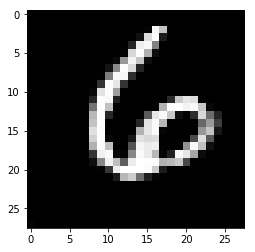

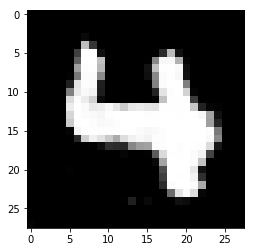

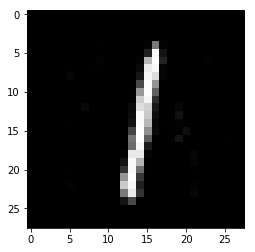

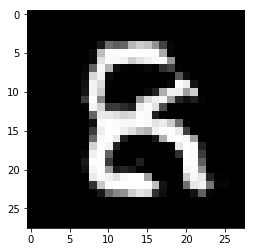

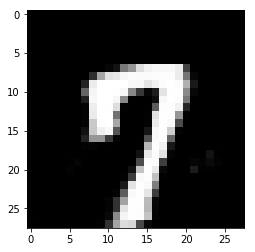

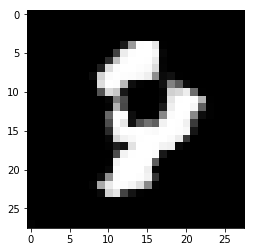

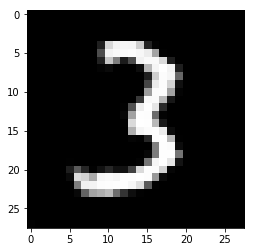

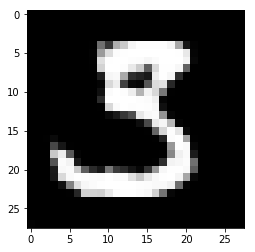

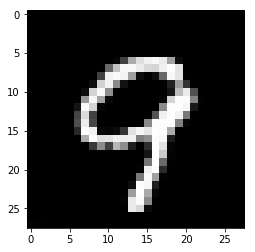

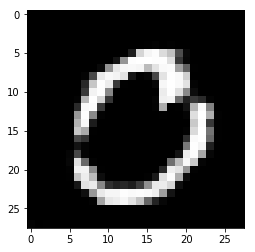

37th iteration gen_loss: 
 2.6014
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5928
[torch.cuda.FloatTensor of size 1 (GPU 0)]

37th iteration gen_loss: 
 2.5623
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6123
[torch.cuda.FloatTensor of size 1 (GPU 0)]

37th iteration gen_loss: 
 2.4929
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6727
[torch.cuda.FloatTensor of size 1 (GPU 0)]

37th iteration gen_loss: 
 2.6689
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6412
[torch.cuda.FloatTensor of size 1 (GPU 0)]

37th iteration gen_loss: 
 2.6176
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6338
[torch.cuda.FloatTensor of size 1 (GPU 0)]

37th iteration gen_loss: 
 2.5650
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6808
[torch.cuda.FloatTensor of size 1 (GPU 0)]

37th iteration gen_loss: 
 2.5335
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6749
[torch.cuda.FloatTensor of size 1 (GPU 0)]

37th iteratio

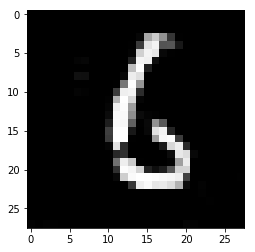

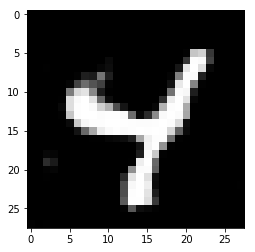

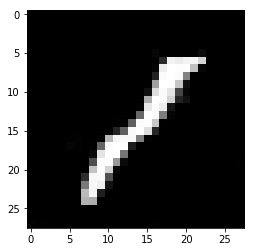

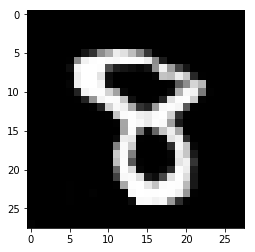

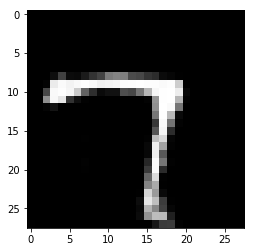

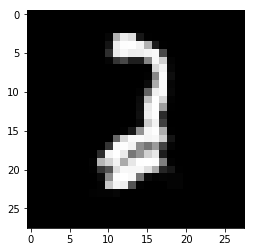

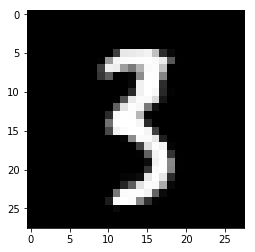

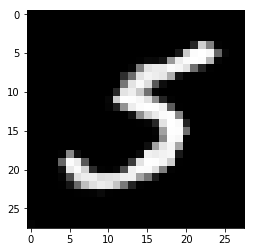

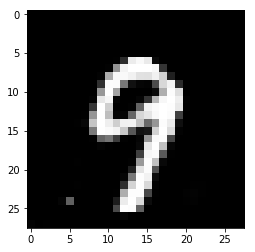

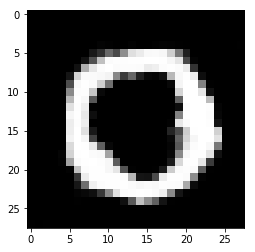

38th iteration gen_loss: 
 2.5255
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5490
[torch.cuda.FloatTensor of size 1 (GPU 0)]

38th iteration gen_loss: 
 2.5400
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6502
[torch.cuda.FloatTensor of size 1 (GPU 0)]

38th iteration gen_loss: 
 2.5573
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5191
[torch.cuda.FloatTensor of size 1 (GPU 0)]

38th iteration gen_loss: 
 2.6837
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5821
[torch.cuda.FloatTensor of size 1 (GPU 0)]

38th iteration gen_loss: 
 2.5958
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6044
[torch.cuda.FloatTensor of size 1 (GPU 0)]

38th iteration gen_loss: 
 2.5655
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5232
[torch.cuda.FloatTensor of size 1 (GPU 0)]

38th iteration gen_loss: 
 2.5475
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6156
[torch.cuda.FloatTensor of size 1 (GPU 0)]

38th iteratio

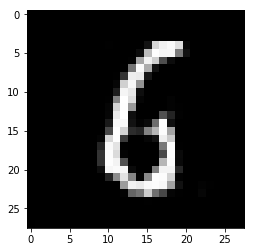

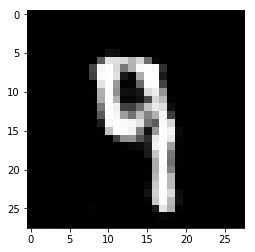

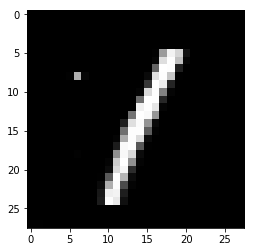

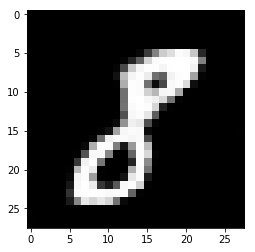

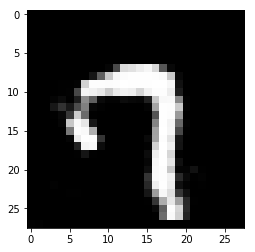

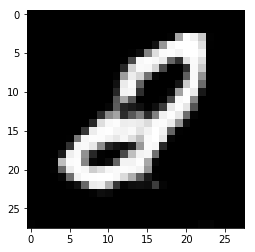

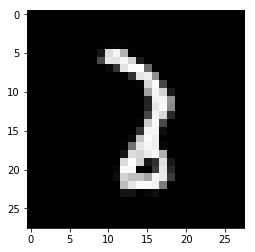

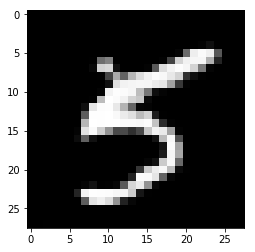

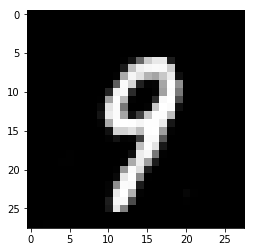

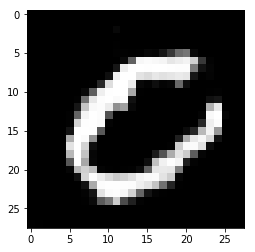

39th iteration gen_loss: 
 2.5063
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6315
[torch.cuda.FloatTensor of size 1 (GPU 0)]

39th iteration gen_loss: 
 2.5986
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6555
[torch.cuda.FloatTensor of size 1 (GPU 0)]

39th iteration gen_loss: 
 2.4113
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5444
[torch.cuda.FloatTensor of size 1 (GPU 0)]

39th iteration gen_loss: 
 2.6583
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6097
[torch.cuda.FloatTensor of size 1 (GPU 0)]

39th iteration gen_loss: 
 2.7044
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6084
[torch.cuda.FloatTensor of size 1 (GPU 0)]

39th iteration gen_loss: 
 2.6986
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6325
[torch.cuda.FloatTensor of size 1 (GPU 0)]

39th iteration gen_loss: 
 2.5478
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6754
[torch.cuda.FloatTensor of size 1 (GPU 0)]

39th iteratio

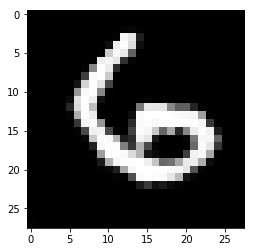

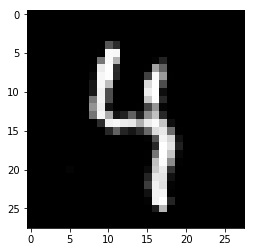

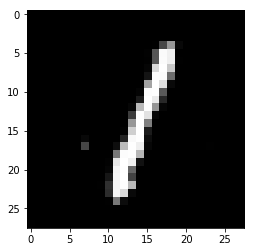

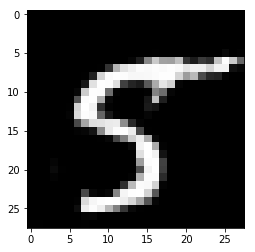

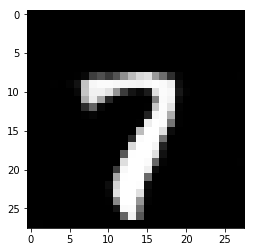

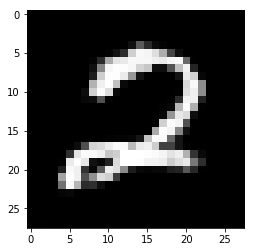

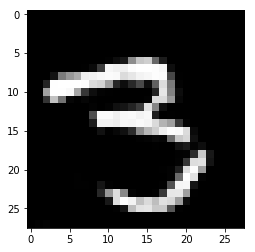

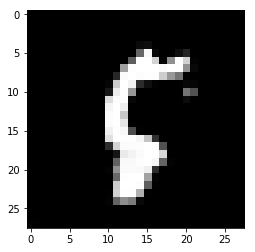

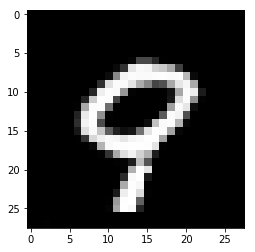

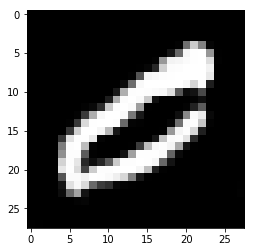

40th iteration gen_loss: 
 2.6569
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5363
[torch.cuda.FloatTensor of size 1 (GPU 0)]

40th iteration gen_loss: 
 2.4353
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5825
[torch.cuda.FloatTensor of size 1 (GPU 0)]

40th iteration gen_loss: 
 2.5058
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6021
[torch.cuda.FloatTensor of size 1 (GPU 0)]

40th iteration gen_loss: 
 2.6138
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6559
[torch.cuda.FloatTensor of size 1 (GPU 0)]

40th iteration gen_loss: 
 2.6369
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5522
[torch.cuda.FloatTensor of size 1 (GPU 0)]

40th iteration gen_loss: 
 2.6165
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5890
[torch.cuda.FloatTensor of size 1 (GPU 0)]

40th iteration gen_loss: 
 2.5865
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5910
[torch.cuda.FloatTensor of size 1 (GPU 0)]

40th iteratio

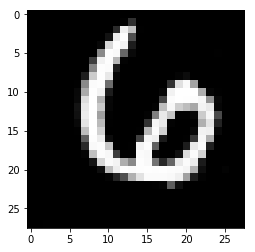

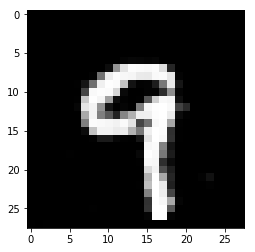

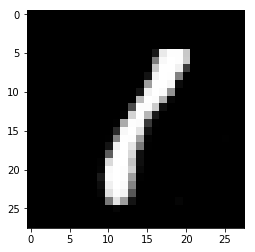

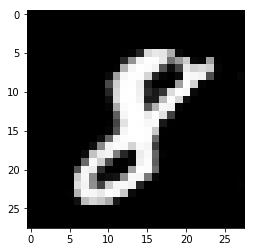

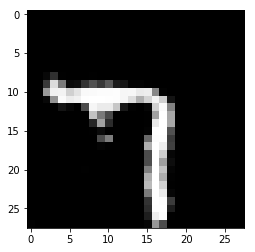

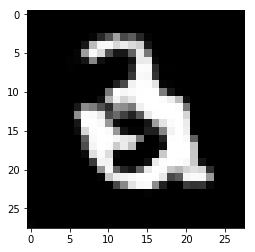

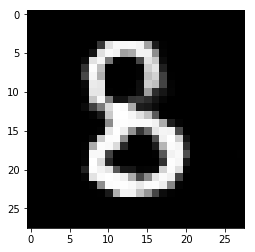

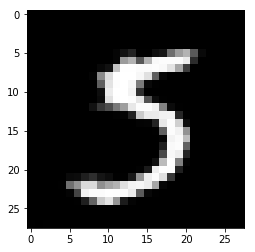

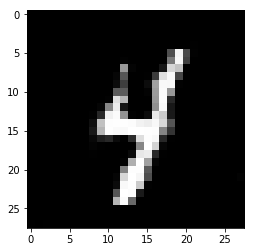

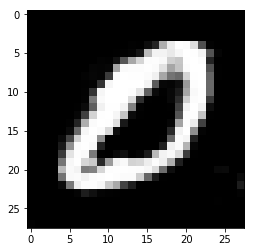

41th iteration gen_loss: 
 2.5015
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5959
[torch.cuda.FloatTensor of size 1 (GPU 0)]

41th iteration gen_loss: 
 2.6165
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6360
[torch.cuda.FloatTensor of size 1 (GPU 0)]

41th iteration gen_loss: 
 2.7129
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6050
[torch.cuda.FloatTensor of size 1 (GPU 0)]

41th iteration gen_loss: 
 2.6468
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5286
[torch.cuda.FloatTensor of size 1 (GPU 0)]

41th iteration gen_loss: 
 2.5859
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5376
[torch.cuda.FloatTensor of size 1 (GPU 0)]

41th iteration gen_loss: 
 2.7409
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5200
[torch.cuda.FloatTensor of size 1 (GPU 0)]

41th iteration gen_loss: 
 2.5665
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5739
[torch.cuda.FloatTensor of size 1 (GPU 0)]

41th iteratio

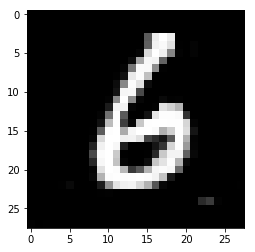

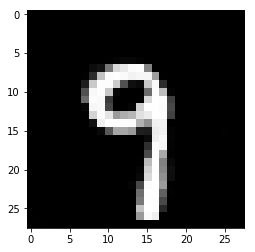

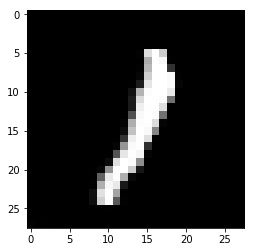

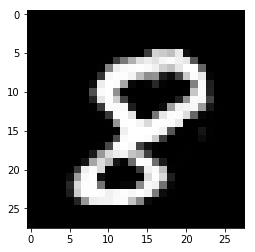

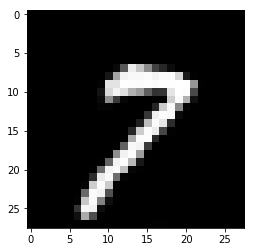

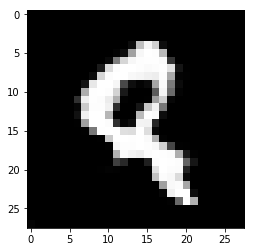

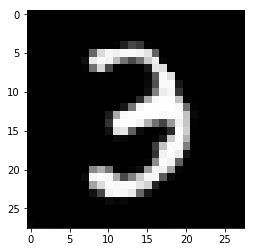

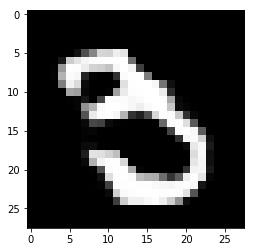

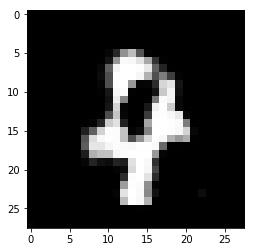

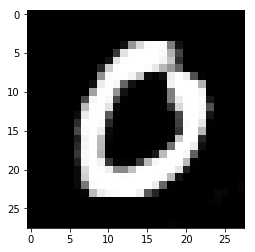

42th iteration gen_loss: 
 2.6037
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4942
[torch.cuda.FloatTensor of size 1 (GPU 0)]

42th iteration gen_loss: 
 2.6722
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5077
[torch.cuda.FloatTensor of size 1 (GPU 0)]

42th iteration gen_loss: 
 2.6145
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4918
[torch.cuda.FloatTensor of size 1 (GPU 0)]

42th iteration gen_loss: 
 2.5440
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6658
[torch.cuda.FloatTensor of size 1 (GPU 0)]

42th iteration gen_loss: 
 2.5579
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5581
[torch.cuda.FloatTensor of size 1 (GPU 0)]

42th iteration gen_loss: 
 2.7307
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5860
[torch.cuda.FloatTensor of size 1 (GPU 0)]

42th iteration gen_loss: 
 2.5373
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5656
[torch.cuda.FloatTensor of size 1 (GPU 0)]

42th iteratio

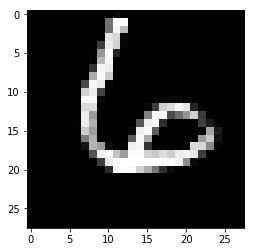

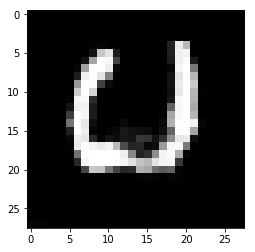

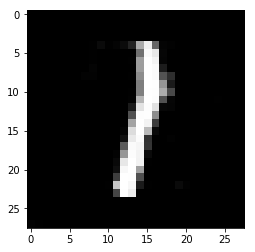

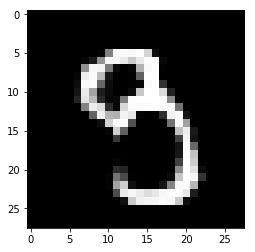

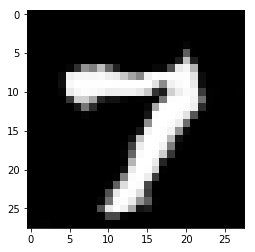

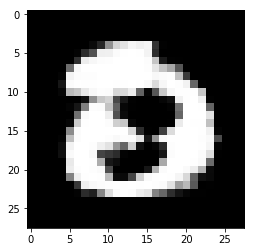

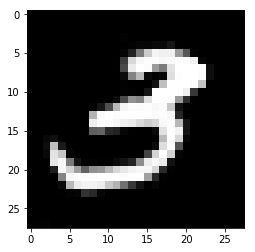

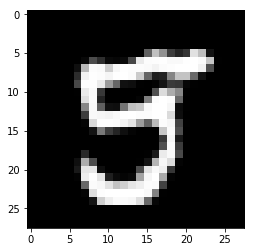

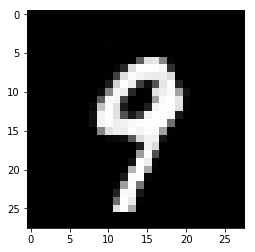

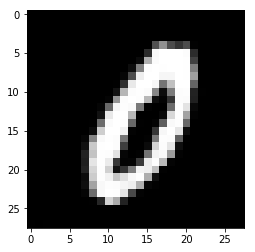

43th iteration gen_loss: 
 2.6352
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6148
[torch.cuda.FloatTensor of size 1 (GPU 0)]

43th iteration gen_loss: 
 2.5137
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6247
[torch.cuda.FloatTensor of size 1 (GPU 0)]

43th iteration gen_loss: 
 2.6044
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5310
[torch.cuda.FloatTensor of size 1 (GPU 0)]

43th iteration gen_loss: 
 2.8604
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7171
[torch.cuda.FloatTensor of size 1 (GPU 0)]

43th iteration gen_loss: 
 2.6870
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.7084
[torch.cuda.FloatTensor of size 1 (GPU 0)]

43th iteration gen_loss: 
 2.6975
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5118
[torch.cuda.FloatTensor of size 1 (GPU 0)]

43th iteration gen_loss: 
 2.6265
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6033
[torch.cuda.FloatTensor of size 1 (GPU 0)]

43th iteratio

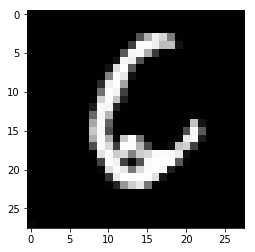

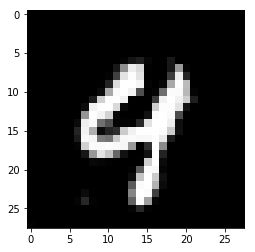

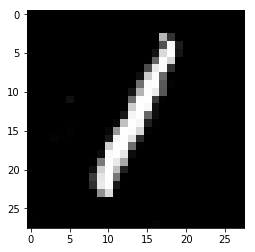

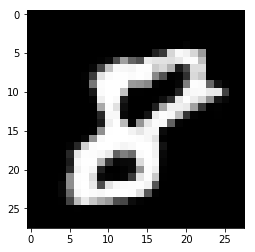

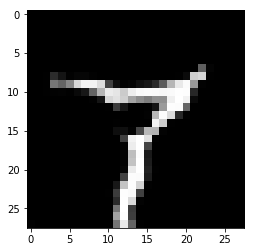

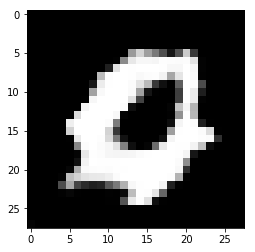

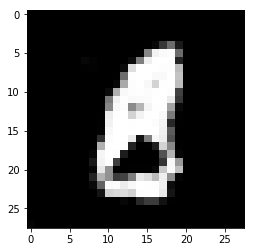

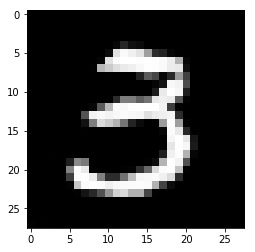

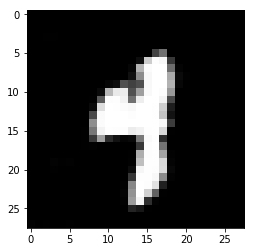

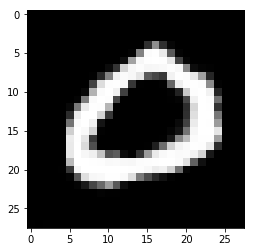

44th iteration gen_loss: 
 2.7850
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4462
[torch.cuda.FloatTensor of size 1 (GPU 0)]

44th iteration gen_loss: 
 2.7016
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5574
[torch.cuda.FloatTensor of size 1 (GPU 0)]

44th iteration gen_loss: 
 2.4548
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5721
[torch.cuda.FloatTensor of size 1 (GPU 0)]

44th iteration gen_loss: 
 2.6998
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5542
[torch.cuda.FloatTensor of size 1 (GPU 0)]

44th iteration gen_loss: 
 2.6043
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5047
[torch.cuda.FloatTensor of size 1 (GPU 0)]

44th iteration gen_loss: 
 2.7038
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5534
[torch.cuda.FloatTensor of size 1 (GPU 0)]

44th iteration gen_loss: 
 2.7025
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4770
[torch.cuda.FloatTensor of size 1 (GPU 0)]

44th iteratio

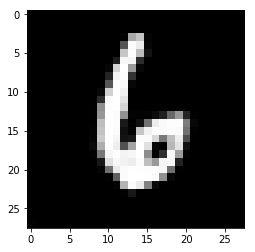

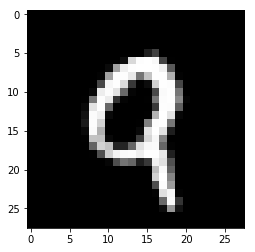

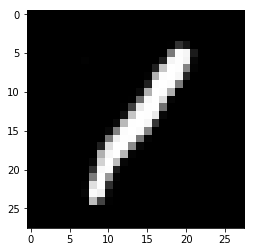

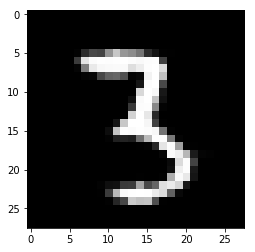

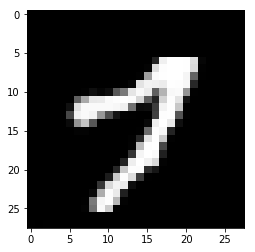

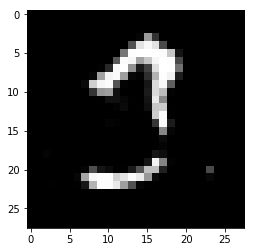

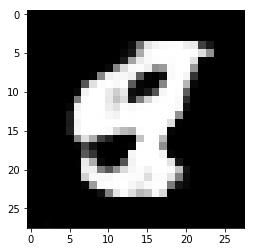

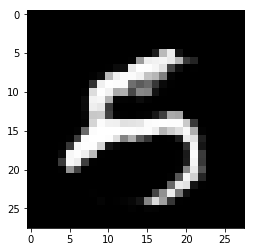

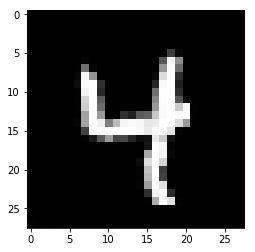

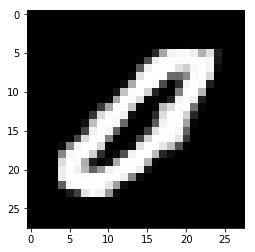

45th iteration gen_loss: 
 2.6363
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6077
[torch.cuda.FloatTensor of size 1 (GPU 0)]

45th iteration gen_loss: 
 2.7090
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5956
[torch.cuda.FloatTensor of size 1 (GPU 0)]

45th iteration gen_loss: 
 2.7548
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4264
[torch.cuda.FloatTensor of size 1 (GPU 0)]

45th iteration gen_loss: 
 2.8442
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4822
[torch.cuda.FloatTensor of size 1 (GPU 0)]

45th iteration gen_loss: 
 2.8432
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.3912
[torch.cuda.FloatTensor of size 1 (GPU 0)]

45th iteration gen_loss: 
 2.6793
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5880
[torch.cuda.FloatTensor of size 1 (GPU 0)]

45th iteration gen_loss: 
 2.6947
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5860
[torch.cuda.FloatTensor of size 1 (GPU 0)]

45th iteratio

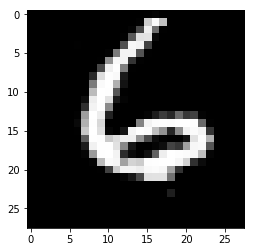

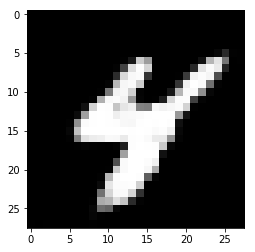

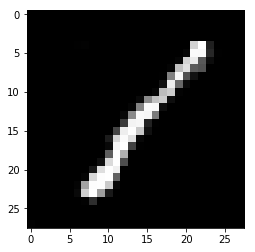

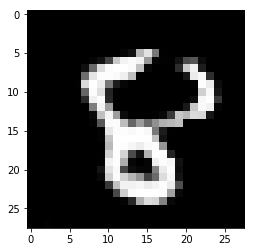

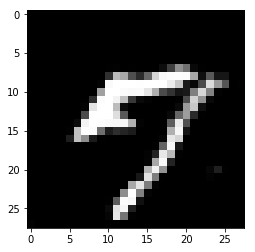

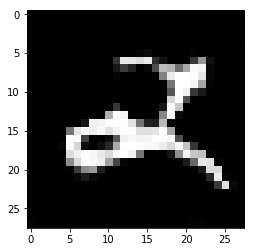

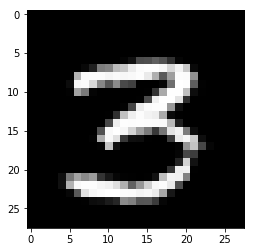

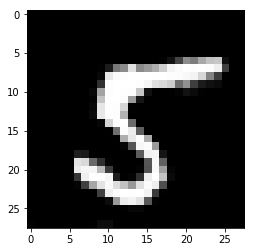

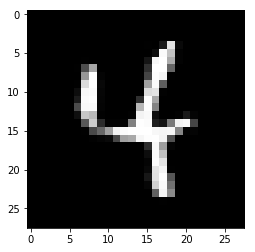

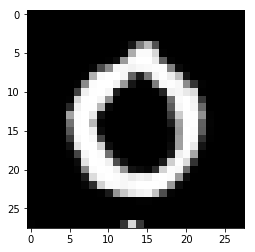

46th iteration gen_loss: 
 2.7689
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6061
[torch.cuda.FloatTensor of size 1 (GPU 0)]

46th iteration gen_loss: 
 2.8468
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4981
[torch.cuda.FloatTensor of size 1 (GPU 0)]

46th iteration gen_loss: 
 2.6265
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5395
[torch.cuda.FloatTensor of size 1 (GPU 0)]

46th iteration gen_loss: 
 2.7638
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4783
[torch.cuda.FloatTensor of size 1 (GPU 0)]

46th iteration gen_loss: 
 2.7049
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5116
[torch.cuda.FloatTensor of size 1 (GPU 0)]

46th iteration gen_loss: 
 2.7419
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4382
[torch.cuda.FloatTensor of size 1 (GPU 0)]

46th iteration gen_loss: 
 2.6750
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5997
[torch.cuda.FloatTensor of size 1 (GPU 0)]

46th iteratio

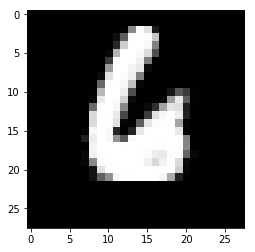

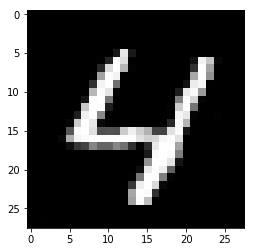

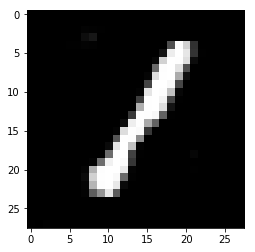

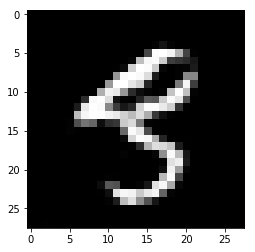

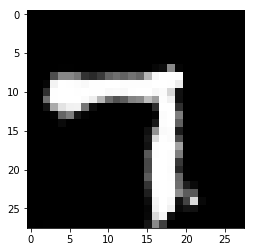

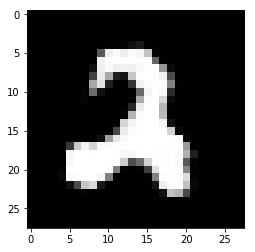

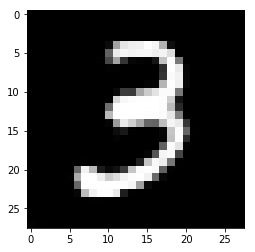

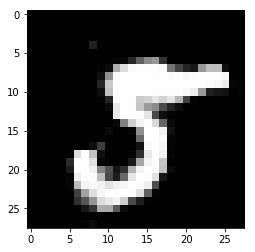

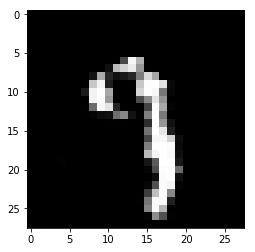

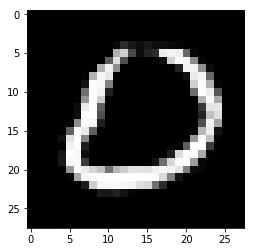

47th iteration gen_loss: 
 2.7664
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5783
[torch.cuda.FloatTensor of size 1 (GPU 0)]

47th iteration gen_loss: 
 2.8037
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6215
[torch.cuda.FloatTensor of size 1 (GPU 0)]

47th iteration gen_loss: 
 2.5946
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4978
[torch.cuda.FloatTensor of size 1 (GPU 0)]

47th iteration gen_loss: 
 2.4928
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6997
[torch.cuda.FloatTensor of size 1 (GPU 0)]

47th iteration gen_loss: 
 2.7030
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5303
[torch.cuda.FloatTensor of size 1 (GPU 0)]

47th iteration gen_loss: 
 2.6290
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6566
[torch.cuda.FloatTensor of size 1 (GPU 0)]

47th iteration gen_loss: 
 2.8195
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5811
[torch.cuda.FloatTensor of size 1 (GPU 0)]

47th iteratio

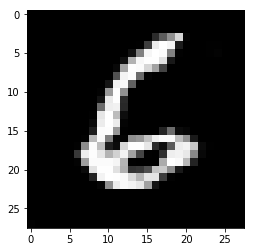

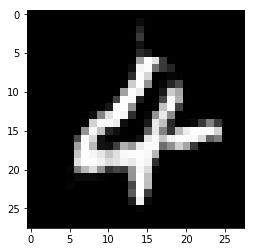

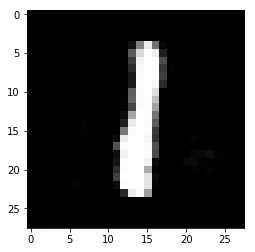

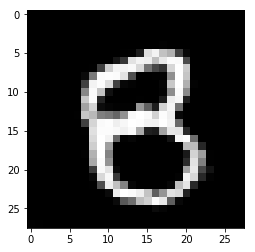

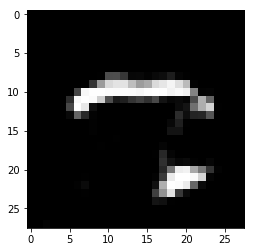

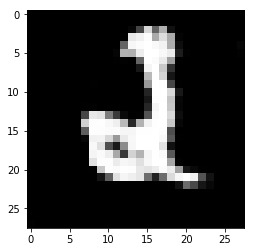

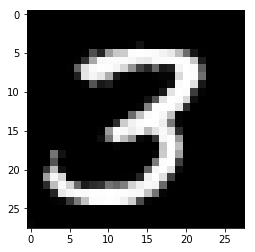

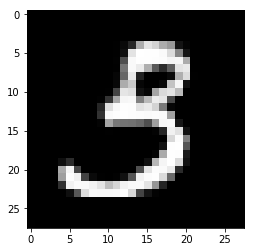

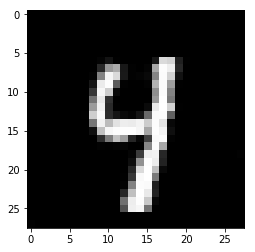

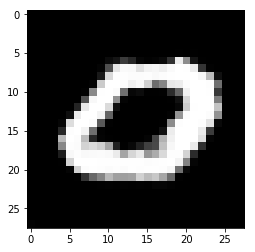

48th iteration gen_loss: 
 2.8529
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5276
[torch.cuda.FloatTensor of size 1 (GPU 0)]

48th iteration gen_loss: 
 2.4738
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5052
[torch.cuda.FloatTensor of size 1 (GPU 0)]

48th iteration gen_loss: 
 2.4770
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5670
[torch.cuda.FloatTensor of size 1 (GPU 0)]

48th iteration gen_loss: 
 2.7076
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6237
[torch.cuda.FloatTensor of size 1 (GPU 0)]

48th iteration gen_loss: 
 2.6322
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.4957
[torch.cuda.FloatTensor of size 1 (GPU 0)]

48th iteration gen_loss: 
 2.6615
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6139
[torch.cuda.FloatTensor of size 1 (GPU 0)]

48th iteration gen_loss: 
 2.8216
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6060
[torch.cuda.FloatTensor of size 1 (GPU 0)]

48th iteratio

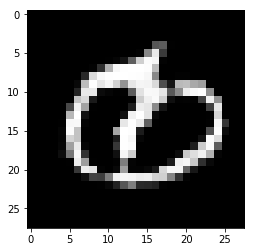

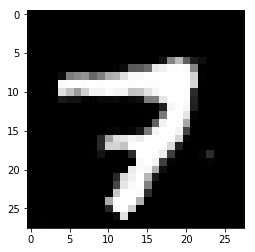

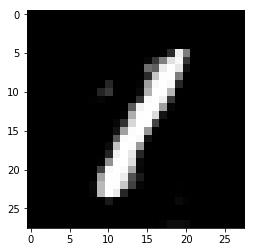

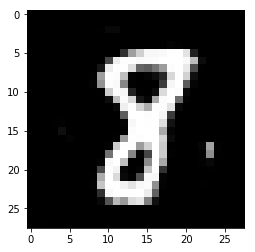

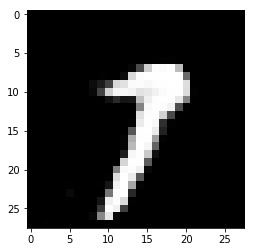

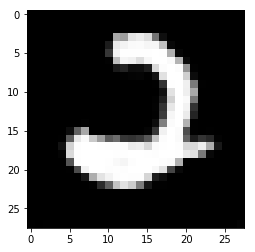

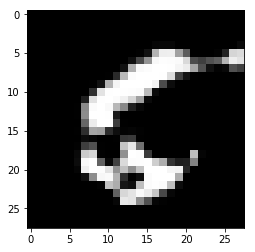

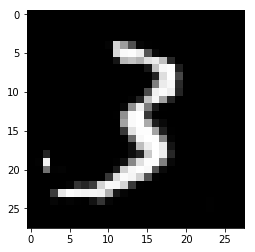

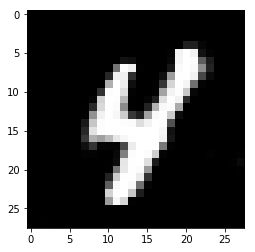

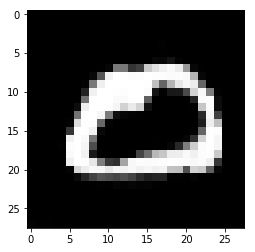

49th iteration gen_loss: 
 2.4900
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5532
[torch.cuda.FloatTensor of size 1 (GPU 0)]

49th iteration gen_loss: 
 2.7609
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5489
[torch.cuda.FloatTensor of size 1 (GPU 0)]

49th iteration gen_loss: 
 2.7790
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5095
[torch.cuda.FloatTensor of size 1 (GPU 0)]

49th iteration gen_loss: 
 2.7397
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5319
[torch.cuda.FloatTensor of size 1 (GPU 0)]

49th iteration gen_loss: 
 2.5743
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6483
[torch.cuda.FloatTensor of size 1 (GPU 0)]

49th iteration gen_loss: 
 2.5979
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.5921
[torch.cuda.FloatTensor of size 1 (GPU 0)]

49th iteration gen_loss: 
 2.4992
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 2.6296
[torch.cuda.FloatTensor of size 1 (GPU 0)]

49th iteratio

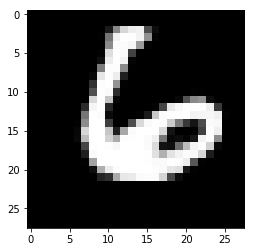

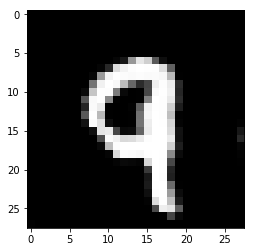

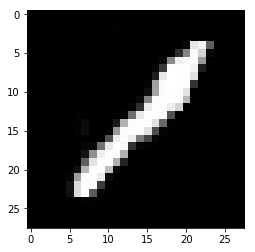

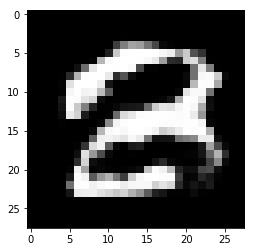

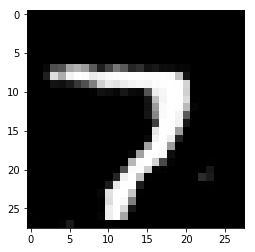

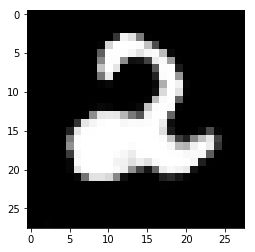

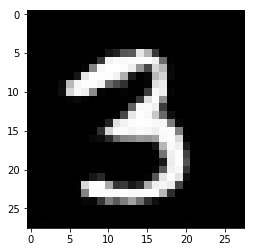

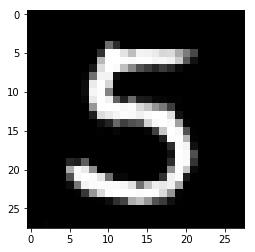

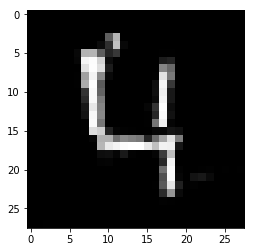

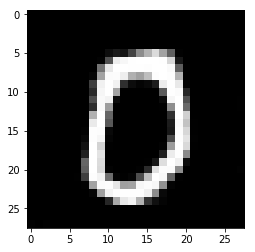

In [10]:
for i in range(epoch):
    for j,(image,_) in enumerate(train_loader):
        
        # put image & label on gpu
        image = Variable(image).cuda()
    
        #####################
        ##  discriminator  ##
        ##################### 
        
        z_random = np.random.normal(0,0.1,size=[batch_size,z_size])
        z_onehot = np.random.randint(0, 10, size=batch_size)
        z_contin = np.random.uniform(-1,1,size=[batch_size,2])

        # change first 10 labels from random to 0~9          
        
        for l in range(10):
            z_onehot[l]=l

        # preprocess z
        
        z_label_onehot = int_to_onehot(z_onehot)
        z_concat = np.concatenate([z_random, z_label_onehot,z_contin], axis=1)

        z = Variable(torch.from_numpy(z_concat).type_as(torch.FloatTensor())).cuda()
        z_label_category = Variable(torch.from_numpy(z_onehot).type_as(torch.LongTensor())).cuda()
        z_label_contin = Variable(torch.from_numpy(z_contin).type_as(torch.FloatTensor())).cuda()
       
        # dis_loss = gan_loss(fake & real) + categorical loss
        
        gen_fake = generator.forward(z)
        dis_fake, onehot_fake, contin_fake = discriminator.forward(gen_fake)
        
        dis_optim.zero_grad()
        dis_real, label_real, contin_real = discriminator.forward(image)
        dis_loss = torch.sum(gan_loss_func(dis_fake,zeros_label))\
                 + torch.sum(gan_loss_func(dis_real,ones_label))\
                 + ratio *(torch.sum(cat_loss_func(onehot_fake,z_label_category))\
                 + torch.sum(contin_loss_func(contin_fake,z_label_contin)))
                
        dis_loss.backward()
        dis_optim.step()
        
        #################
        ##  generator  ##
        #################
            
        z_random = np.random.normal(0,0.1,size=[batch_size,z_size])
        z_onehot = np.random.randint(0, 10, size=batch_size)
        z_contin = np.random.uniform(-1,1,size=[batch_size,2])

        # change first 10 labels from random to 0~9   
        
        for l in range(10):
            z_onehot[l]=l

        # preprocess z
        
        z_label_onehot = int_to_onehot(z_onehot)
        z_concat = np.concatenate([z_random, z_label_onehot,z_contin], axis=1)

        z = Variable(torch.from_numpy(z_concat).type_as(torch.FloatTensor())).cuda()
        z_label_category = Variable(torch.from_numpy(z_onehot).type_as(torch.LongTensor())).cuda()
        z_label_contin = Variable(torch.from_numpy(z_contin).type_as(torch.FloatTensor())).cuda()


        # gen_loss = gan loss(fake) + categorical loss
        
        gen_optim.zero_grad()
        gen_fake = generator.forward(z)
        dis_fake, onehot_fake, contin_fake = discriminator.forward(gen_fake)
        
        
        gen_loss = torch.sum(gan_loss_func(dis_fake,ones_label)) \
                 + ratio *(torch.sum(cat_loss_func(onehot_fake,z_label_category))\
                 + torch.sum(contin_loss_func(contin_fake,z_label_contin)))

        gen_loss.backward()
        gen_optim.step()

        # model save
        
        if j % 10 == 0:
            torch.save([generator,discriminator],'./model/infogan_catcon.pkl')

            # print loss and image save
            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            v_utils.save_image(gen_fake.data[0:20],"./result_catcon/gen_{}_{}.png".format(i,j), nrow=5)
        
    image_check(gen_fake.cpu())
    contin_check(i)